# 24 hr samples analysis 

Notes - https://docs.google.com/document/d/1Br8UvdCUWuVcuBxhohyOSbF-BmxKyLEfYVnFUqITHJA/edit?tab=t.0

In [22]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.dates import DateFormatter
from matplotlib.dates import HourLocator
from scipy.stats import sem

## Reading in the data & processing

In [4]:
marti_reads = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/24_hour/taxa_counts/marti_assignments_lca_0.1_all_levels_23_and_24_2025-FEB-28_16-50-48.tsv", sep="\t")

def process_dataset(data):
    # Select the first 3 columns using indexing
    first_three_cols = data.iloc[:, :3]
    # Select columns where the column name contains 'summed'
    summed_cols = data.filter(like='Summed')
    summed_cols.columns = summed_cols.columns.str.split(' ').str[0]
    # Combine the first three columns with the 'summed' columns
    data_summed = pd.concat([first_three_cols, summed_cols], axis=1)
    
    return data_summed

marti = process_dataset(marti_reads)

### Metadata 
- Still need to get contig stats for the 200k subsampled **2023** reads
- Collections is from a [google doc](https://docs.google.com/spreadsheets/d/1Oh7zeWlQewzo9bDmnu5cenVM5a9zddVSlzS5OcUnhaE/edit?gid=196309316#gid=196309316) which is kept updated (Specifically the 24 hour collections sheet)
- Contig stats were generated on the HPC and downloaded using the scripts in this [repo](https://github.com/Mia-FGB/hpc-scripts)
    - Still need to run this for 200k subsampled 2023 data
- read numbers were generated from the marti JSON files using get_read_numbers script

In [5]:
collections = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/24_hour/metadata/All metadata - 24 hour collections (2023 & 2024).tsv", sep="\t") 
collections['Start_Time'] = pd.to_datetime(collections['Start_Time'])
collections['End_Time'] = pd.to_datetime(collections['End_Time'])
collections['Start_Date'] = collections['Start_Time'].dt.date

contig_stats_24 = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/24_hour/metadata/2024_metadata/combined_200k_contig_stats.tsv", sep="\t")
contig_stats_24['Barcode'] = contig_stats_24['Barcode'].str.extract(r'(\d{2})$').astype(int)

read_numbers = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/24_hour/metadata/all_read_numbers.tsv", sep="\t")   

### Merge on all the metadata and calculate HPM

In [6]:
#Melt the data to long
marti_long = marti.melt(
    id_vars = ['Name', 'NCBI ID', 'NCBI Rank'],           # the columns we want to keep
    var_name = 'Sample',    # the name of the new column with old column names (to contain the cols we are combining)
    value_name = 'read count' # the name of the new column with old column values
)

# Merge the metadata with the long data
marti_meta = marti_long.merge(collections, left_on='Sample', right_on='Sample_ID', how='inner')
marti_meta.drop(columns=['Sample_ID'], inplace=True)

# # Merge the contig stats with the long data on barcode - skipping whilst I don't have data for 23
# marti_meta = marti_meta.merge(contig_stats_24, left_on='Barcode', right_on='Barcode')

# #Merge the read numbers on Sample and ID
marti_meta = marti_meta.merge(read_numbers, left_on='Sample', right_on='ID')


## Check if any samples are lost
# marti_meta['Sample'].nunique() # Should be 98
# lost_samples = set(marti_long['Sample']) - set(marti_meta['Sample'])
# print(f"Lost samples: {lost_samples}")



### Calculate HPM etc.

In [7]:
# Calculate various metrics and add them as new columns
metrics = {
    'Relative Abundance': lambda row: row['read count'] / row['ReadsPassBasecall'] * 100,
    'Log Relative Abundance': lambda row: np.log(row['ReadsPassBasecall'] + 1),
    'HP100k': lambda row: (row['read count'] / row['ReadsPassBasecall']) * 100000,
    'Log HP100k': lambda row: np.log((row['read count'] / row['ReadsPassBasecall']) * 100000 + 1),
    'HPM': lambda row: (row['read count'] / row['ReadsPassBasecall']) * 1000000,
    'Log HPM': lambda row: np.log((row['read count'] / row['ReadsPassBasecall']) * 1000000)
}

for metric, func in metrics.items():
    marti_meta[metric] = marti_meta.apply(func, axis=1)

# Replace the -inf values with 0 for 'Log HPM'
marti_meta['Log HPM'] = marti_meta['Log HPM'].replace(-np.inf, 0)

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_94799/3394255012.py:8: RuntimeWarning: divide by zero encountered in log
  'Log HPM': lambda row: np.log((row['read count'] / row['ReadsPassBasecall']) * 1000000)


## Looking at collection metadata

<Axes: xlabel='Duration_Hrs', ylabel='Counts'>

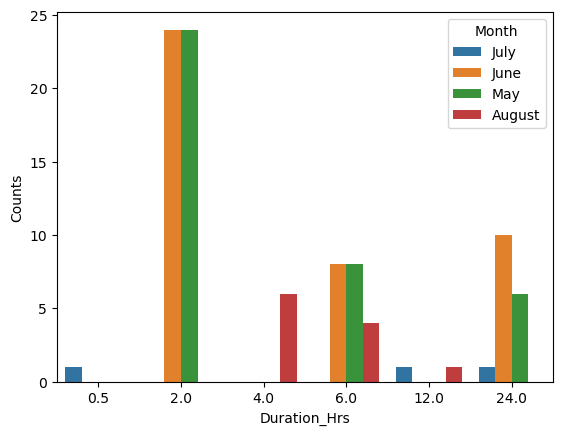

In [8]:
month_duration = collections.groupby(['Duration_Hrs', 'Month']).size().reset_index(name='Counts')
month_duration = month_duration[month_duration['Duration_Hrs'] > 0]

day_duration = collections.groupby(['Duration_Hrs', 'Start_Date']).size().reset_index(name='Counts')
day_duration = day_duration.sort_values(by='Start_Date')
# Convert Start_Date to string for hue
day_duration['Start_Date'] = day_duration['Start_Date'].astype(str)

# bar chart showing how many samples were taken for each duration
# additional 24 hr samples were collected on other days
# sns.barplot(data=day_duration,
#             x='Duration_Hrs',
#             y='Counts',
#             hue='Start_Date')

#Just month - can see additional June 24 hr samples
sns.barplot(data=month_duration,
            x='Duration_Hrs',
            y='Counts',
            hue='Month')

### DNA yield and collection duration

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_94799/3761845989.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_collections['Duration_Hrs'] = filtered_collections['Duration_Hrs'].dropna().astype(int)
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_94799/3761845989.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_collections['LPM'] = filtered_collections['LPM'].astype(str).str.split('.').str[0]


Text(0, 0.5, 'DNA Yield (ng)')

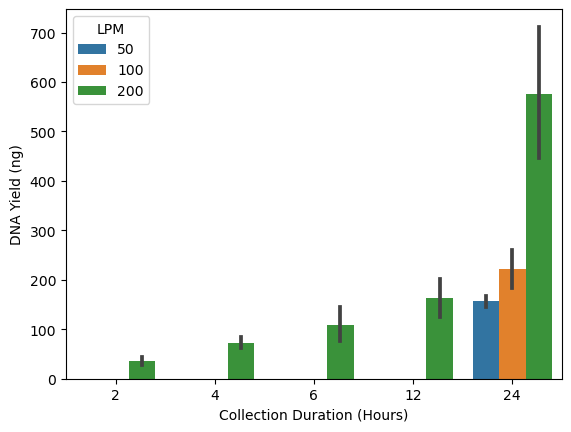

In [9]:
#filtering out the 0.5 sample as it was collected in the lab so not comparable to the field 
filtered_collections = collections[(collections['Duration_Hrs'] > 0.5)]
#Dropping na and making the numbers look nicer
filtered_collections['Duration_Hrs'] = filtered_collections['Duration_Hrs'].dropna().astype(int)

# Convert LPM to string to avoid AttributeError
filtered_collections['LPM'] = filtered_collections['LPM'].astype(str).str.split('.').str[0]

# Define the specific order for LPM values
lpm_order = ['50', '100', '200']

# Set the order for the hue in the barplot
sns.barplot(data=filtered_collections,
            x='Duration_Hrs',
            y='DNA_yield_ng',
            hue='LPM',
            hue_order=lpm_order)

# Set x and y labels
plt.xlabel('Collection Duration (Hours)')
plt.ylabel('DNA Yield (ng)')

# plt.savefig('../Graphs/DNA_yield_vs_duration_lpm.png')

# Pathogens of interest 
 Specifically looking at 9 pathogens and how they behave 
 - Puccinia, Blumeria, Fusarium, Zymoseptoria, Ustilago, Magnaporthe, Pyrenophora, Claviceps, Parastagonospora / Phaeosphaeria

Steps of analysis 
- Collapse summed reads to genus level & Filter to just these pathogens
- Plot pathogens over time, facet by genera name
- Probably want months as seperate graphs
- But could plot durations on the same graph as I did last time, plotting by the middle of the time collectd for now
- Need to think about how to filter out low abundance reads that are likely inaccurate whilst retaining the data point at 0 if it's been filtered out

In [10]:
pathogen_genera = ["Puccinia", "Blumeria", "Fusarium", "Zymoseptoria", "Ustilago", "Magnaporthe",
                    "Claviceps", "Pyrenophora", "Parastagonospora", "Phaeosphaeria"]

pathogen_reads  = marti_meta[(marti_meta['NCBI Rank'] == 'genus') &
                           (marti_meta['Name'].isin(pathogen_genera)) &
                           (~marti_meta['Duration_Hrs'].isin([24, 12, 0.5])) &
                           (marti_meta['Duration_Hrs'].notna())] # Filter out NA samples

pathogen_reads.loc[:, 'Mid'] = pathogen_reads['Start_Time'] + (pathogen_reads['End_Time'] - pathogen_reads['Start_Time']) / 2

#Can use this along the x-axis
pathogen_reads['Collection'] = pathogen_reads['Start_Time'].dt.strftime('%d %b\n%H:%M') + ' -\n ' + pathogen_reads['End_Time'].dt.strftime('%H:%M')

pathogen_reads['Duration_Hrs'] = pathogen_reads['Duration_Hrs'].astype(int)

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_94799/878914303.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathogen_reads.loc[:, 'Mid'] = pathogen_reads['Start_Time'] + (pathogen_reads['End_Time'] - pathogen_reads['Start_Time']) / 2
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_94799/878914303.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathogen_reads['Collection'] = pathogen_reads['Start_Time'].dt.strftime('%d %b\n%H:%M') + ' -\n ' + pathogen_reads['End_Time'].dt.s

Point for every hour, keep it consistent across the duration e.g. in a 6 hour collection plot every hour at the measured HPM

In [11]:
# Generate hourly timestamps
pathogen_reads['Hour'] = pathogen_reads.apply(lambda row: pd.date_range(row['Start_Time'], row['End_Time'], freq='H'), axis=1)

# Expand dataset by exploding the Hour column
expanded_pathogen_reads = pathogen_reads.explode('Hour')

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_94799/984377594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathogen_reads['Hour'] = pathogen_reads.apply(lambda row: pd.date_range(row['Start_Time'], row['End_Time'], freq='H'), axis=1)


## Plots

### Line graph can plot this with pathogen or expanded pathofen data

/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

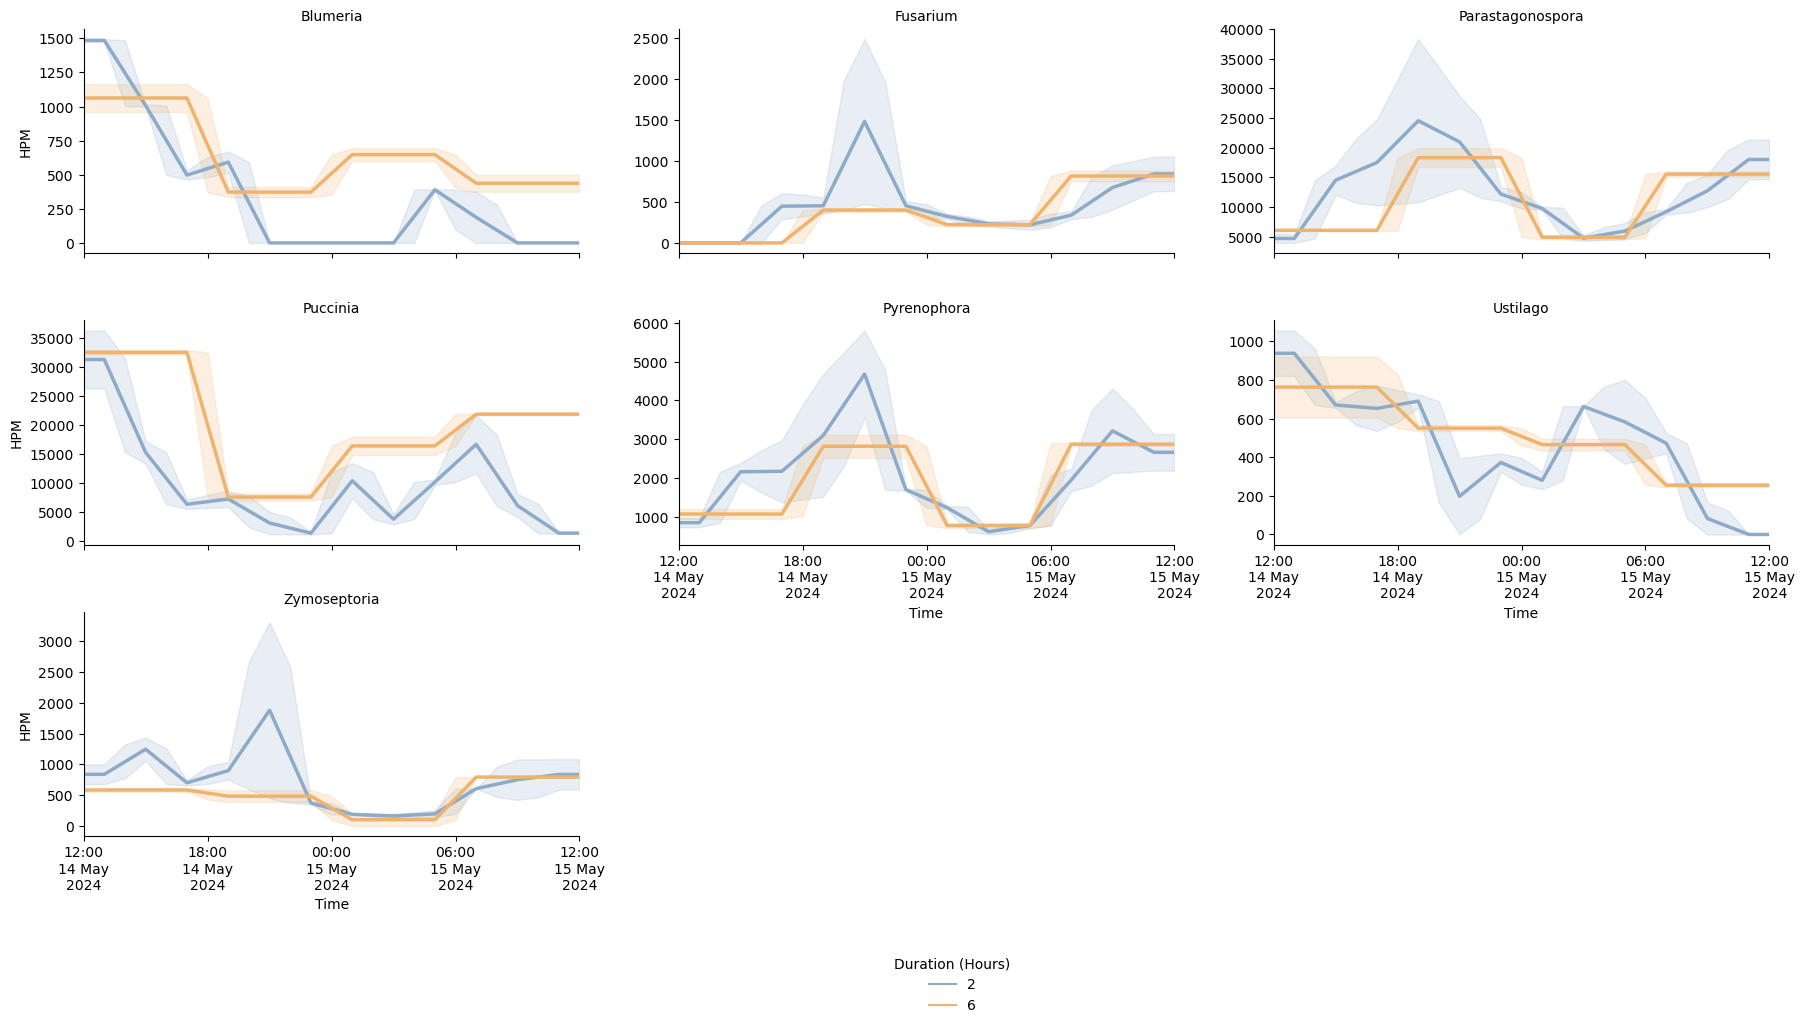

In [12]:
# Filter the data for June / May
june_pathogen = expanded_pathogen_reads[(expanded_pathogen_reads['Month'] == 'June')]
may_pathogen = expanded_pathogen_reads[(expanded_pathogen_reads['Month'] == 'May')]
pathogen_23 = expanded_pathogen_reads[(expanded_pathogen_reads['Year'] == 2023)]

#Choose one of the three filters to plot one at a time 
fungi_species_filter = may_pathogen
# Sort species alphabetically
sorted_genus = fungi_species_filter['Name'].sort_values().unique()

# Get the time range of your data
min_time = fungi_species_filter['Start_Time'].min()
max_time = fungi_species_filter['End_Time'].max()

# Create a FacetGrid with scatter plots for points and line plots to connect them, faceted by species / Genus
g = sns.FacetGrid(
    fungi_species_filter,
    col="Name",
    col_wrap=3,
    col_order=sorted_genus,
    sharey=False, 
    height = 3,
    aspect = 2,
)

# Create line plots within each facet (connecting lines)
g.map_dataframe(
    sns.lineplot,
    x="Hour",  # For expanded pathogen data
    y="HPM",
    hue="Duration_Hrs",
    palette={2: '#8DABC8', 6: '#F0B36D'}, #2024 data
    # palette={4: '#c09ca4', 6: '#F0B36D'},   #2023 data
    linewidth=2.5  # Set the desired line width
)

#Think it looks better without these
# g.map_dataframe(
#     sns.scatterplot,
#     x="Hour",
#     y="HPM",
#     s=20,
#     hue="Duration_Hrs",
#     palette={2: '#8DABC8', 6: '#F0B36D'},
#     legend=False
# )

# Set x-axis properties for each subplot
g.set_axis_labels("Time", "HPM")
g.set_titles("{col_name}", fontweight = 'medium', fontsize = 50)  # Set titles based on species

# Set x-axis properties for all subplots
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(HourLocator(interval=6))  # Set 6-hourly intervals
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M\n%d %b\n%Y'))  # Format x-axis to show day, month, year and hours:minutes
    # ax.tick_params(axis='x', rotation=60)  # Rotate x-axis labels for better readability

    # Set x-axis limits from min_time to max_time
    ax.set_xlim([min_time, max_time])

# Adjust space between plots
g.figure.subplots_adjust(wspace=0.2, hspace=0.3)  # Adjust the width and height space between subplots

# Add legend to the bottom right
g.add_legend(title='Duration (Hours)', bbox_to_anchor=(0.5, -0.1), loc='center')
plt.figsize=(15, 10)

# Different names for input data
# plt.savefig('../Graphs/pathogen_graphs/August_23_all_pathogens.svg')
# plt.savefig('../Graphs/pathogen_graphs/June_24_all_pathogens.svg')
# plt.savefig('../Graphs/pathogen_graphs/May_24_all_pathogens.svg')


## Bar plot for each disease rel abundance over time

In [37]:
def plot_bar_disease(data, month, year, disease, duration, colour):
    filtered_data = pathogen_reads[(pathogen_reads['Month'] == month) &
                                   (pathogen_reads['Year'] == year) &
                                   (pathogen_reads['Name'] == disease) &
                                   (pathogen_reads['read count'] > 5)] # can change this filtering to be

    #Only retain collection, Name and HPM column
    filtered_data = filtered_data[['Collection', 'Name', 'HPM', 'Start_Time', 'Duration_Hrs']]

    if filtered_data.empty:
        max_HPM = 100
    else:
        max_HPM = filtered_data['HPM'].max() + 50 #To give the graph some space

    # Ensure gaps are represented on the graphs - need to add in 0 values
    # Get unique Collection times from the full dataset 
    unique_collections = pathogen_reads[
        (pathogen_reads['Month'] == month) &
        (pathogen_reads['Year'] == year) &
        (pathogen_reads['Duration_Hrs'] == duration)
    ]['Collection'].unique()

    #Create a dataframe where Name is Fusarium and HPM is 0 for all unique collections
    # Create a DataFrame with all possible combinations of Collection and Name
    all_combinations = pd.DataFrame([(c, disease) for c in unique_collections], columns=['Collection', 'Name'])
    all_combinations['HPM'] = 0

    # Merge to get the Start_Time & Duration_Hrs column from pathogen_reads based on Collection
    all_combinations = all_combinations.merge(
        pathogen_reads[['Collection', 'Start_Time', 'Duration_Hrs']].drop_duplicates(), 
        on='Collection', 
        how='left'
    )

    # Concatenate the filtered data with the all_combinations DataFrame
    filtered_data = pd.concat([filtered_data, all_combinations], ignore_index=True)

    # Order the data by the Start_Time column
    filtered_data = filtered_data.sort_values(by='Start_Time')

    #Set plot dimensions
    plt.figure(figsize=(10, 8))

    ax = sns.barplot(data=filtered_data[filtered_data['Duration_Hrs'] == duration],
                    x='Collection',
                    y='HPM',
                    color=colour,
                    ci=None)
        
    # Set the y-axis limits
    ax.set_ylim(0, max_HPM)

    # Add title & labels
    plt.title(f'{disease} - {duration}hrs {month} {year}')
    plt.xlabel('Collection Time')
    plt.ylabel('Relative Abundance (HPM)')

    # Save the plot
    plt.savefig(f'../Graphs/pathogen_graphs/{disease}/{disease}_{duration}hrs_{month}_{year}.svg')


/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_94799/1314918516.py:44: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=filtered_data[filtered_data['Duration_Hrs'] == duration],
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_94799/1314918516.py:44: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=filtered_data[filtered_data['Duration_Hrs'] == duration],
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_94799/1314918516.py:44: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=filtered_data[filtered_data['Duration_Hrs'] == duration],
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_94799/1314918516.py:44: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=filtered_data[filtered_dat

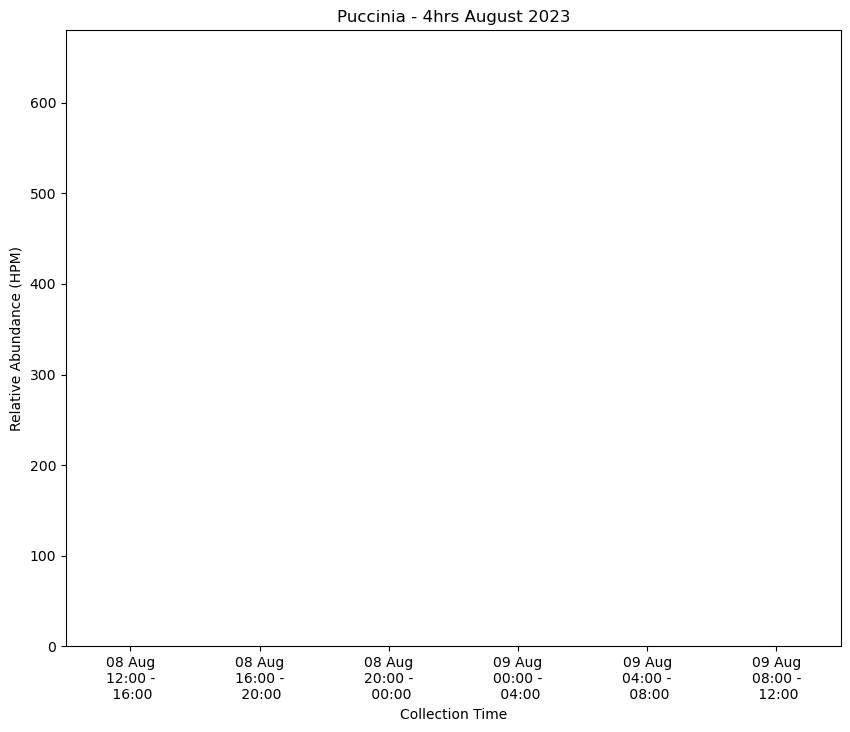

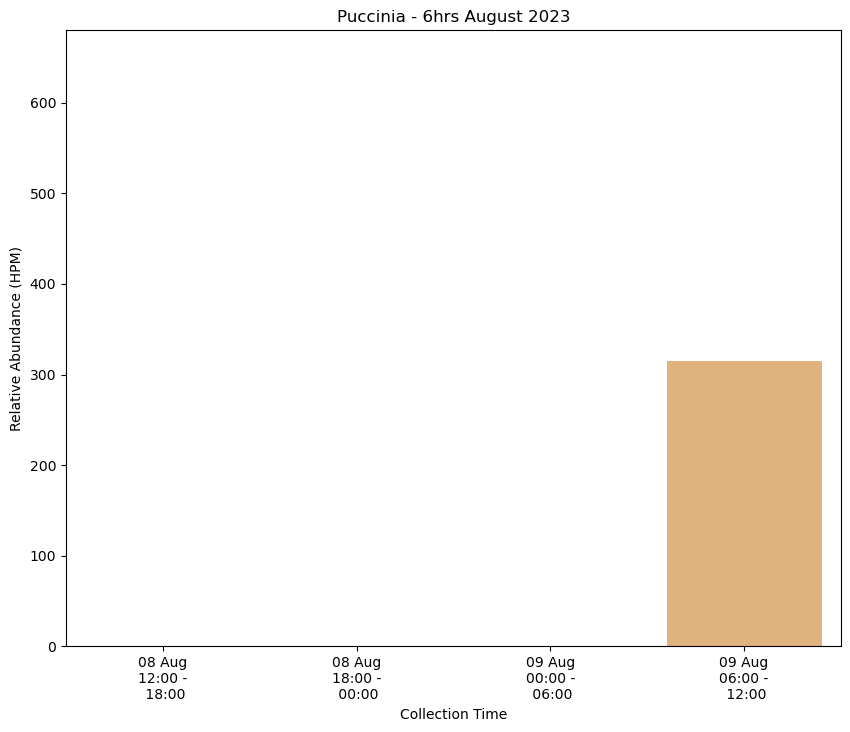

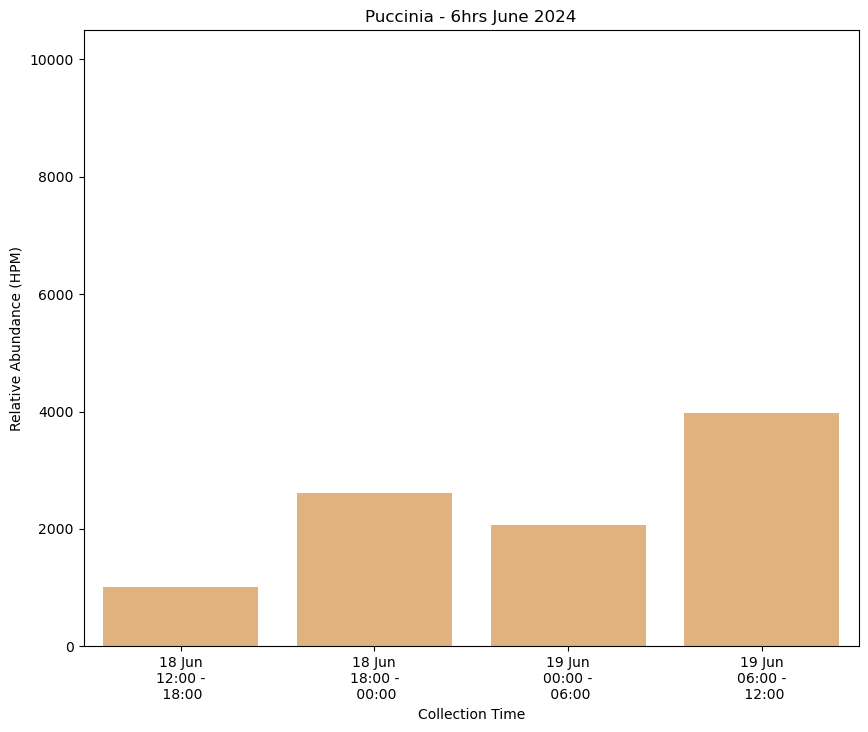

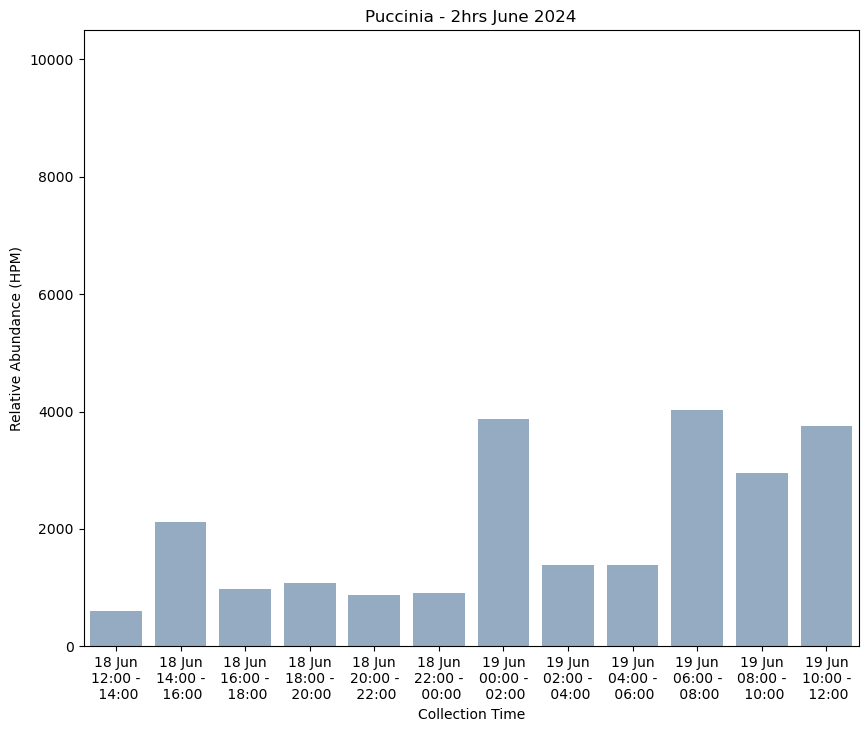

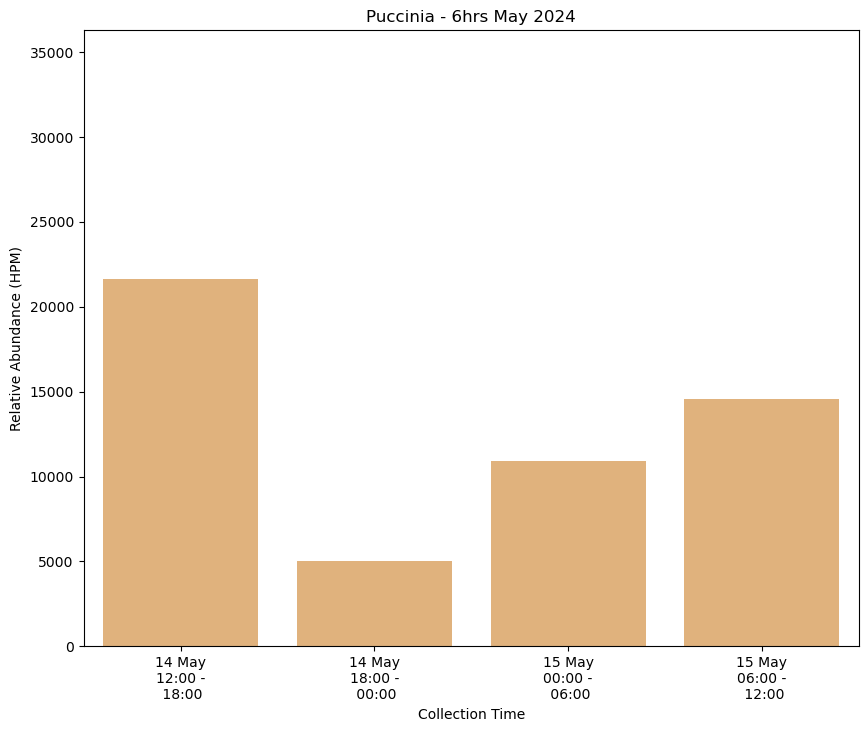

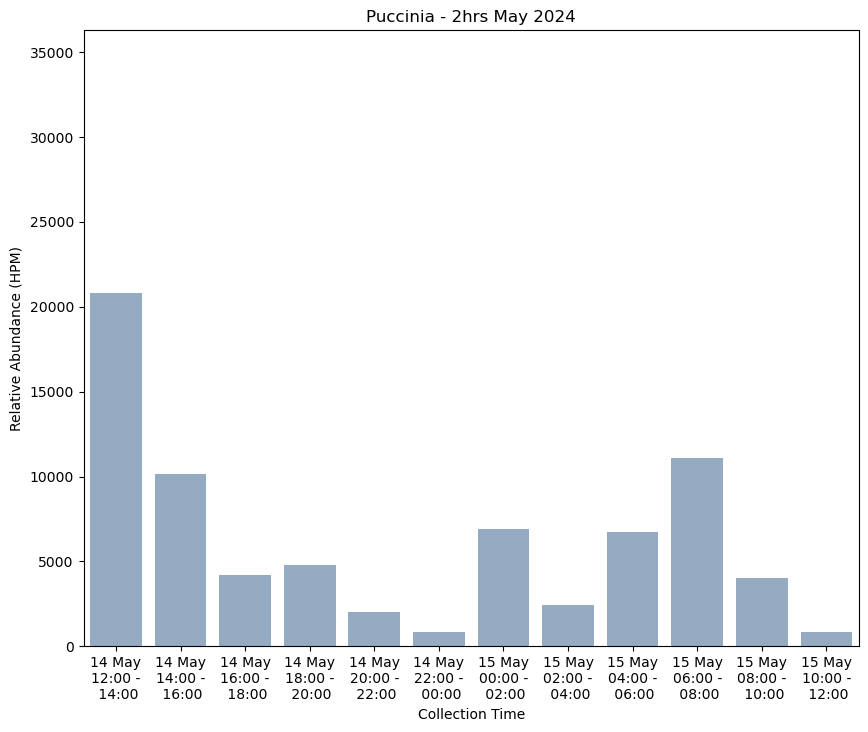

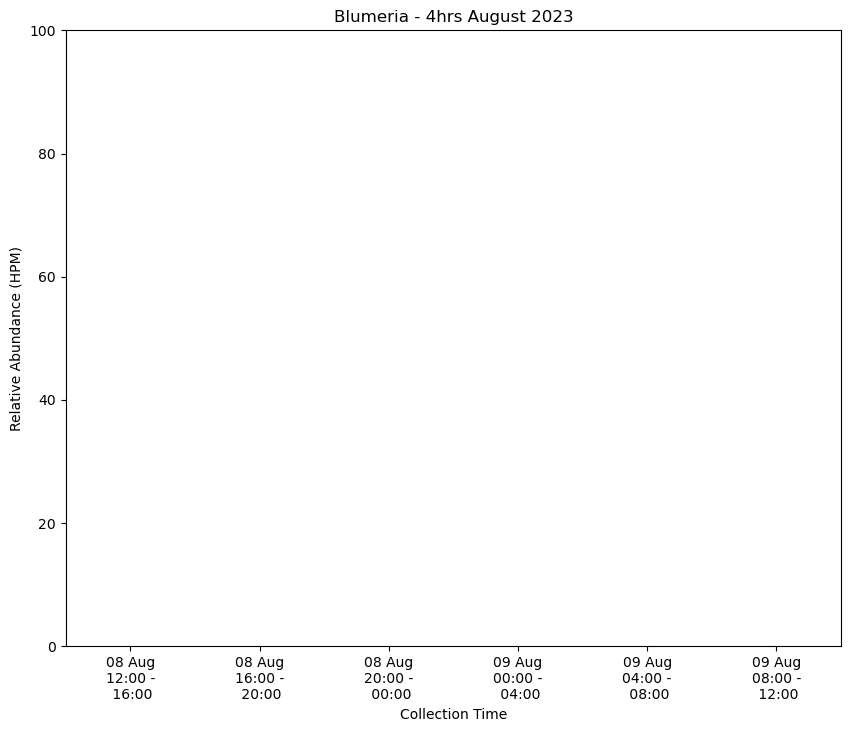

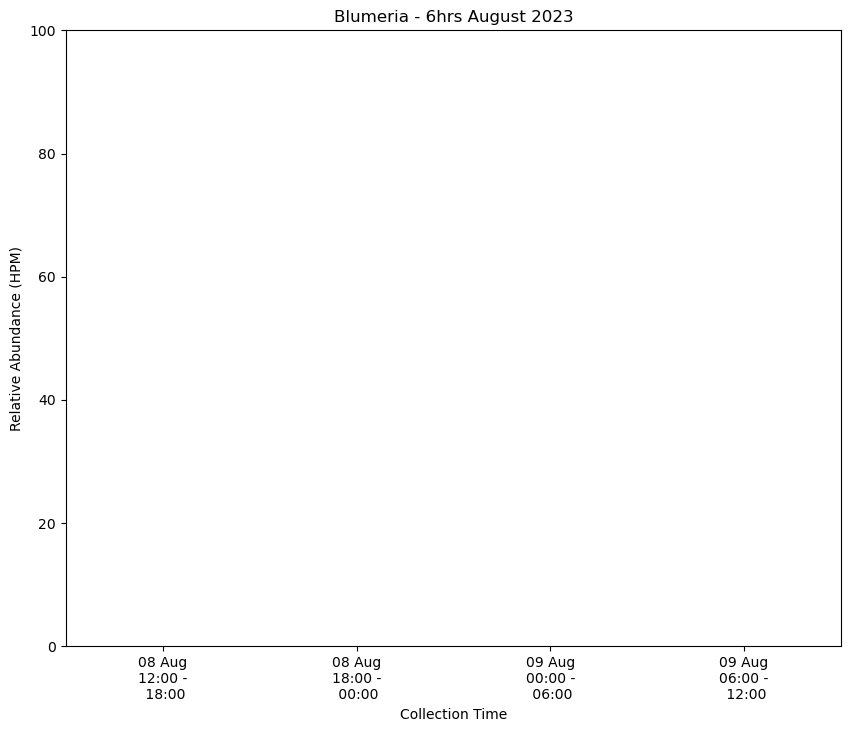

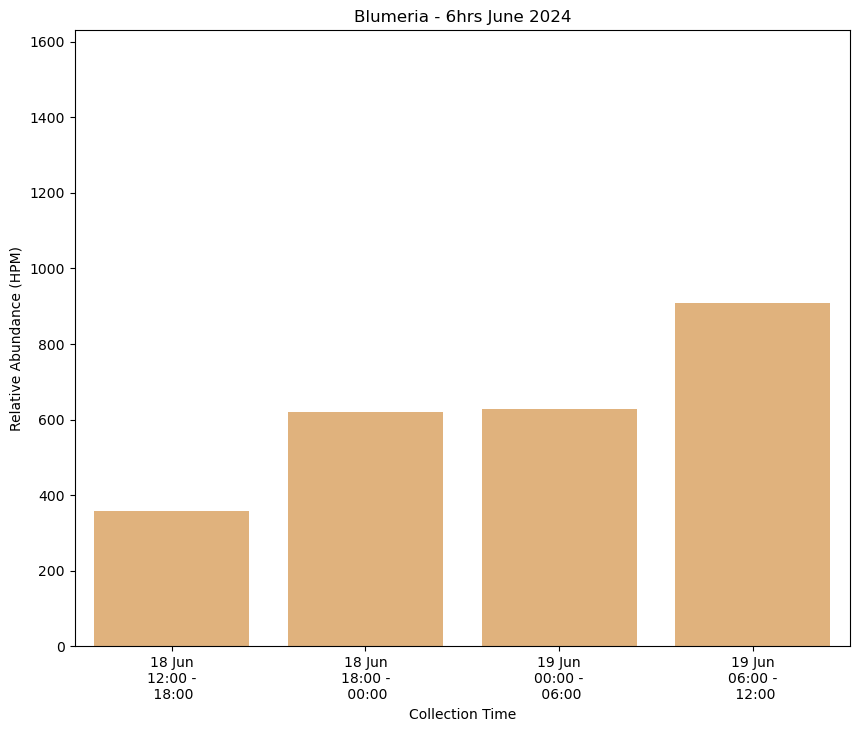

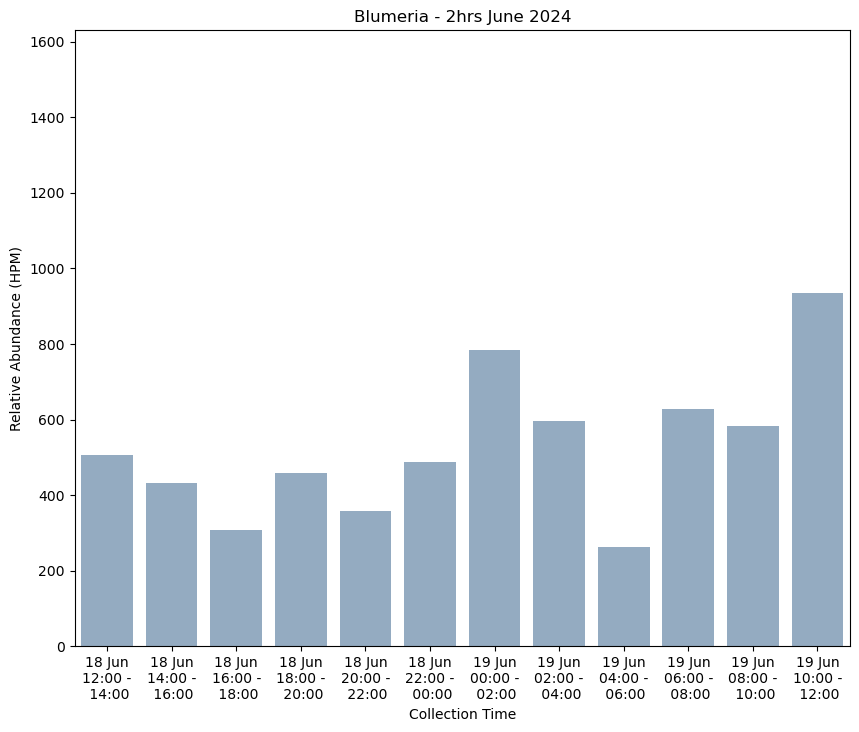

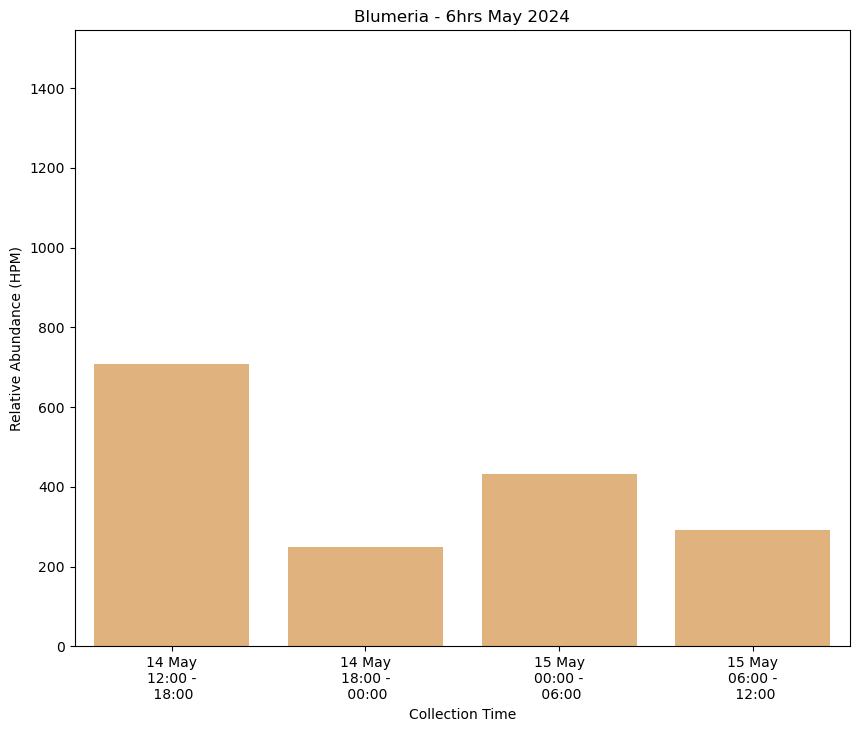

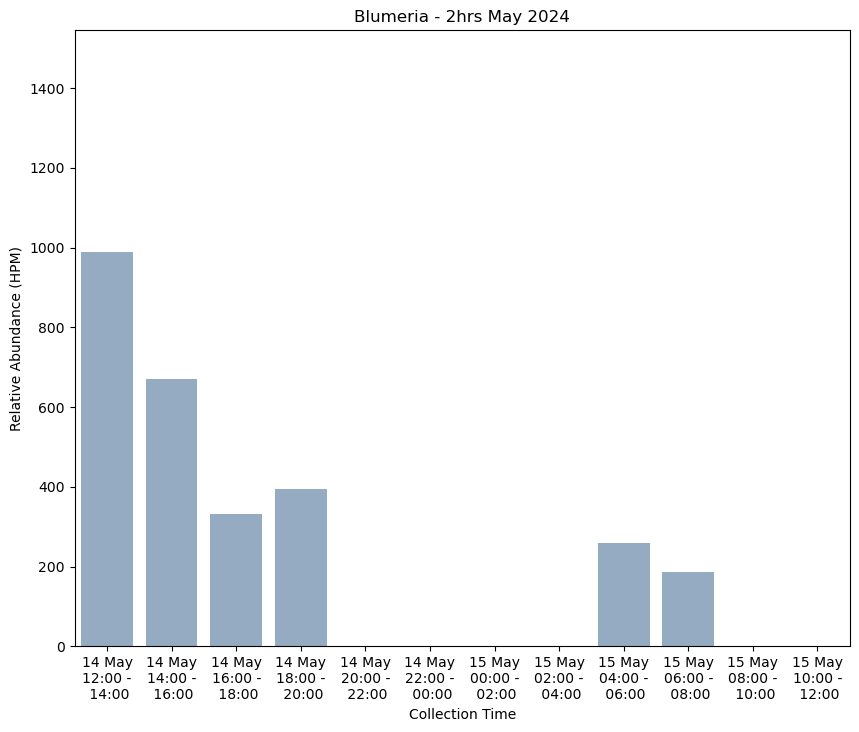

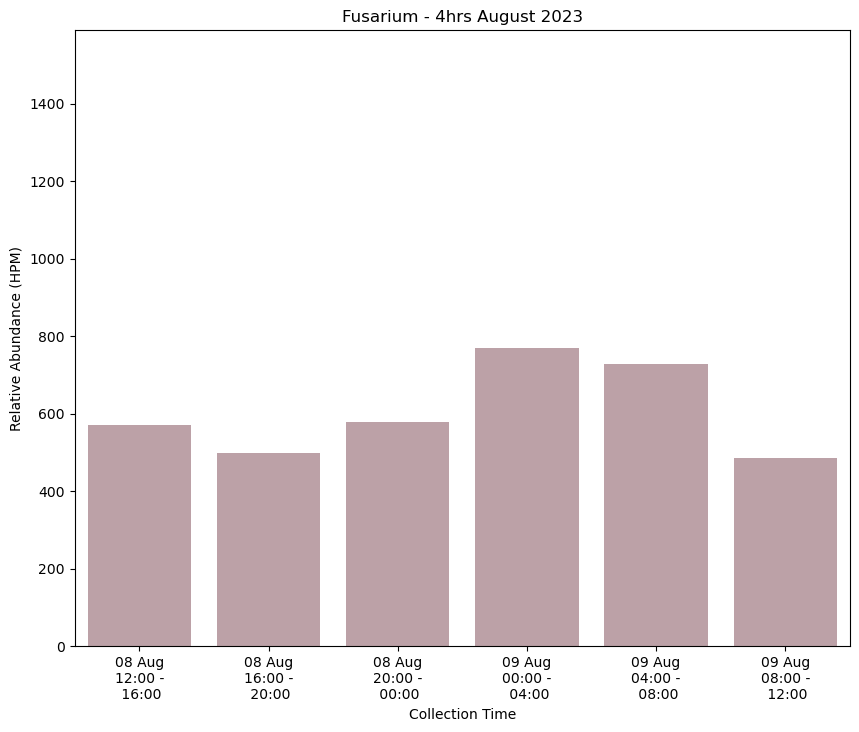

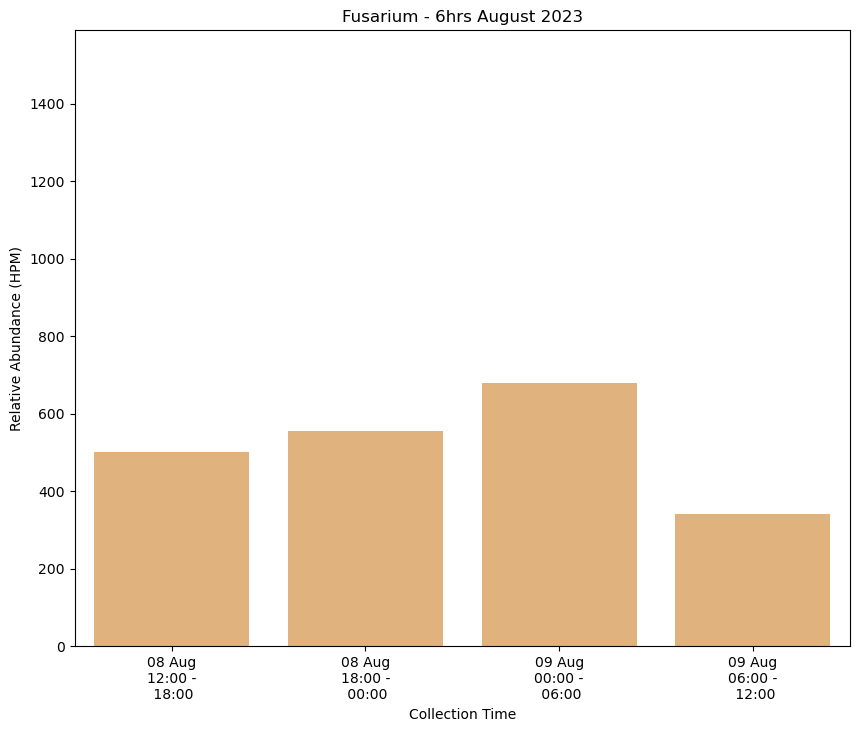

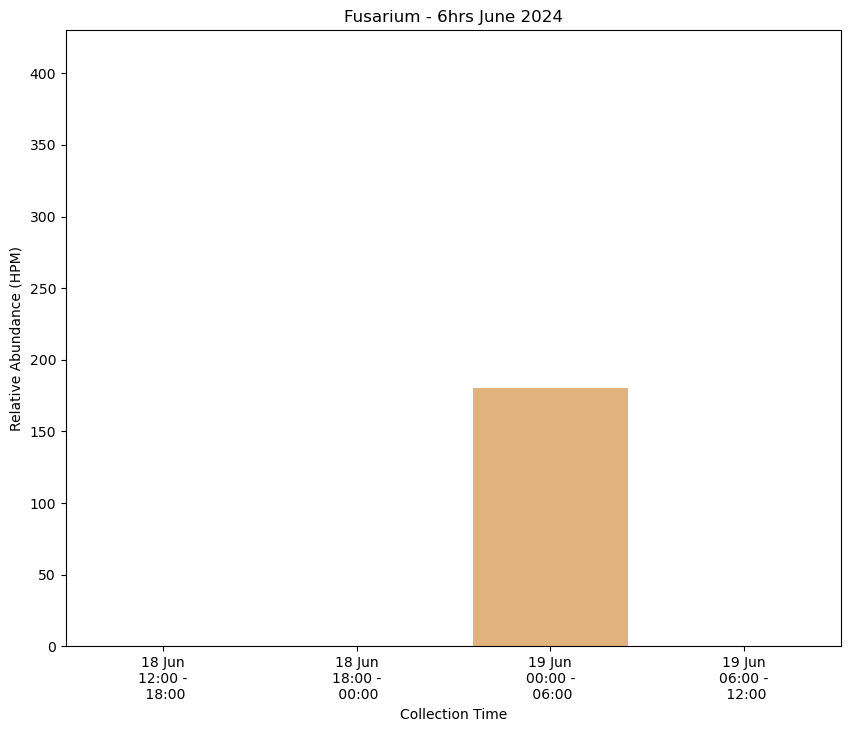

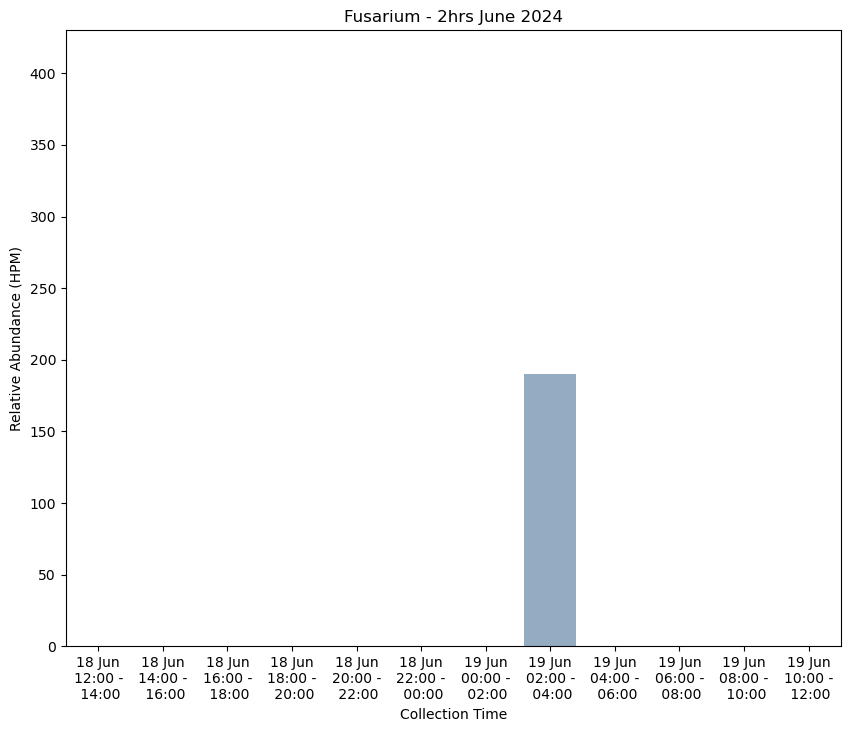

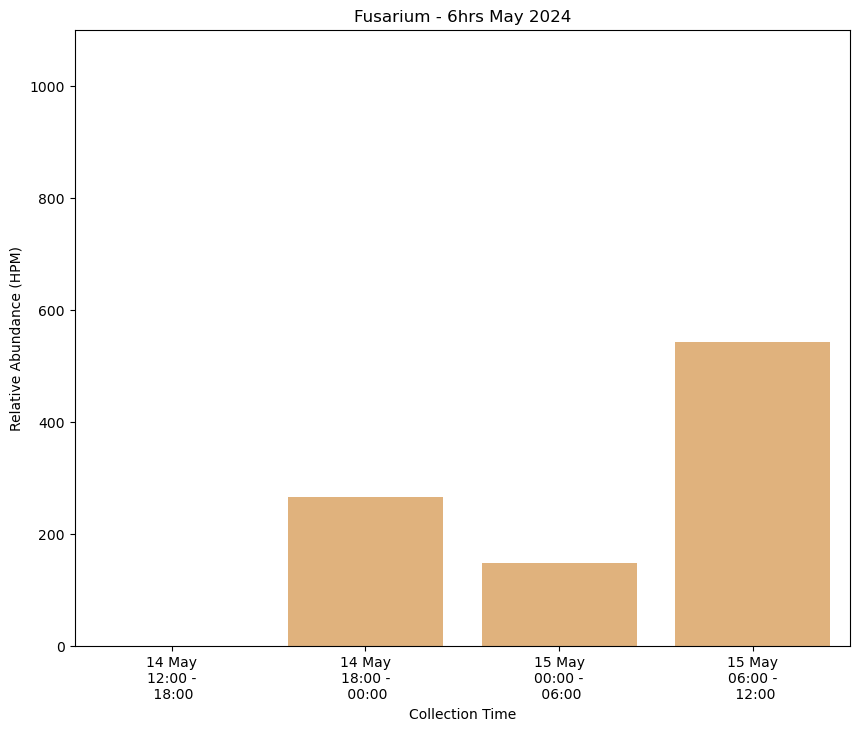

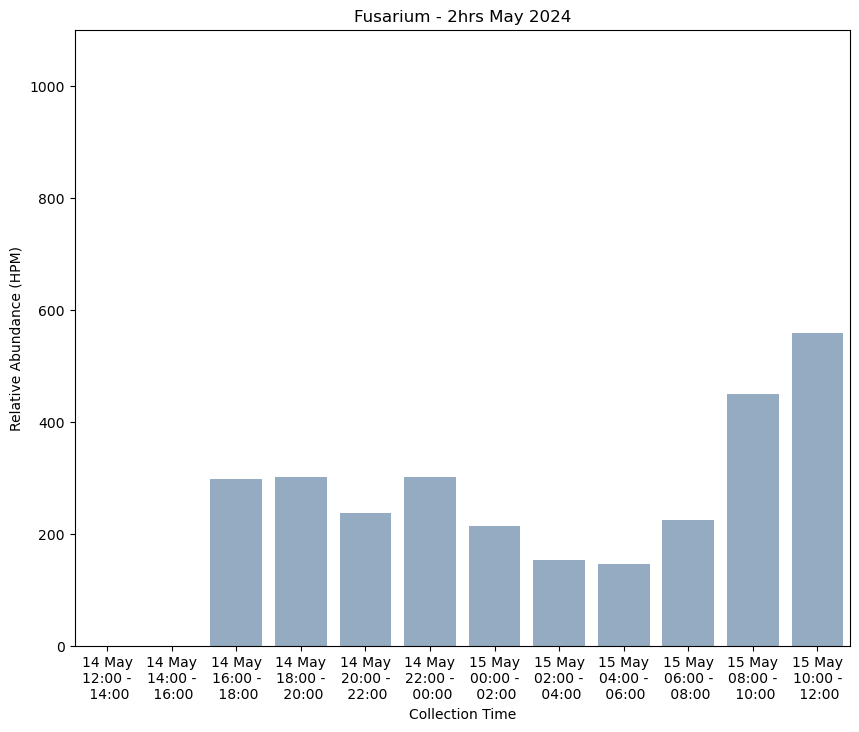

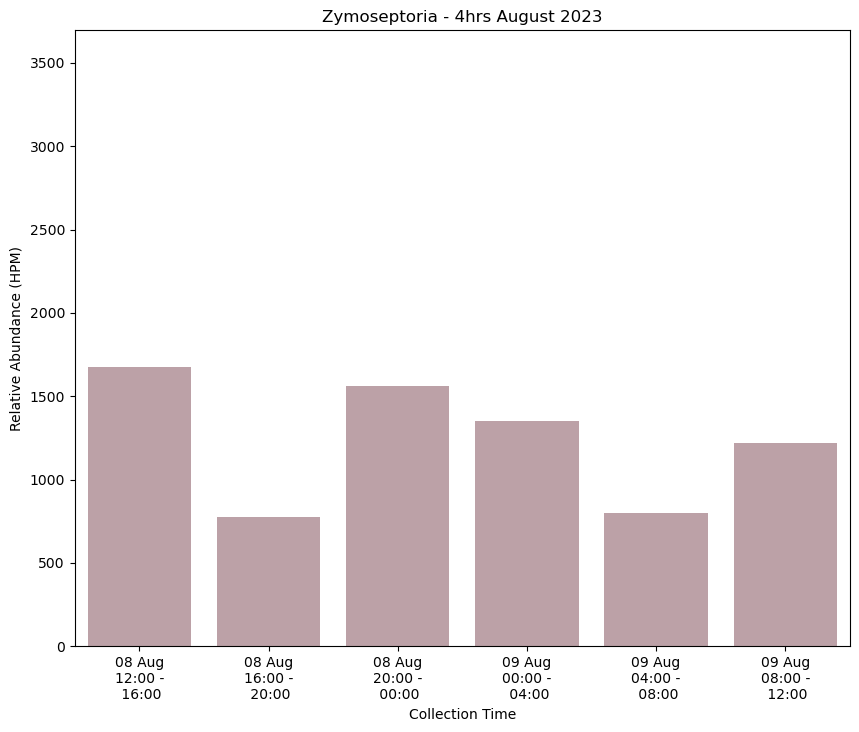

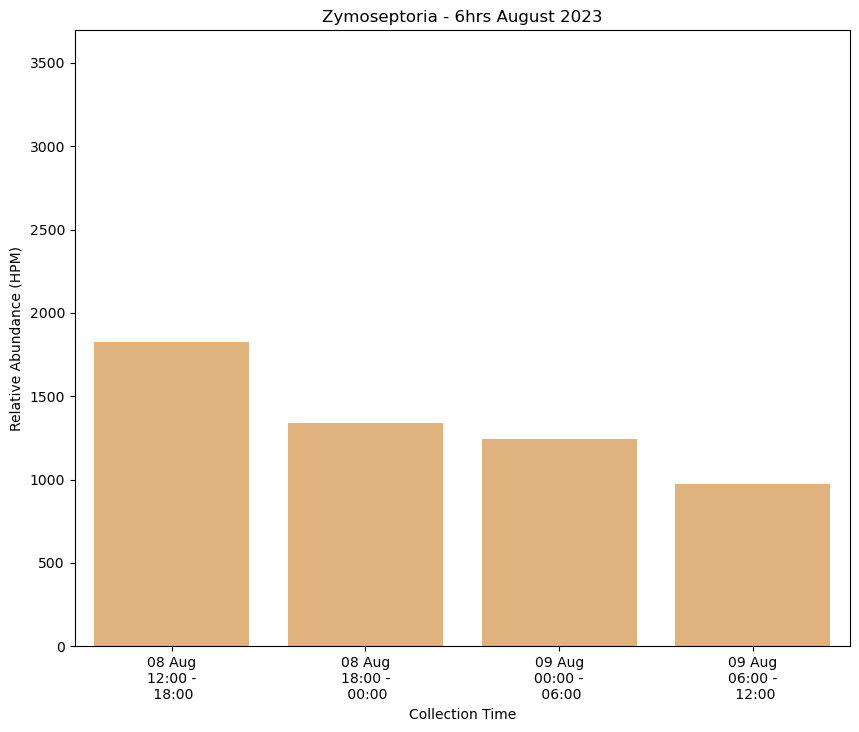

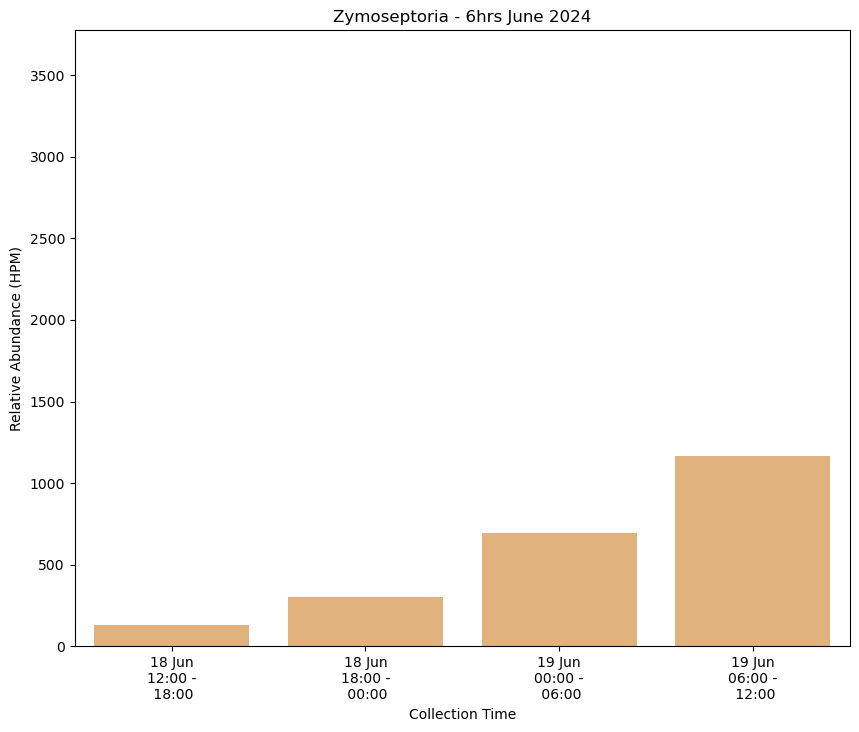

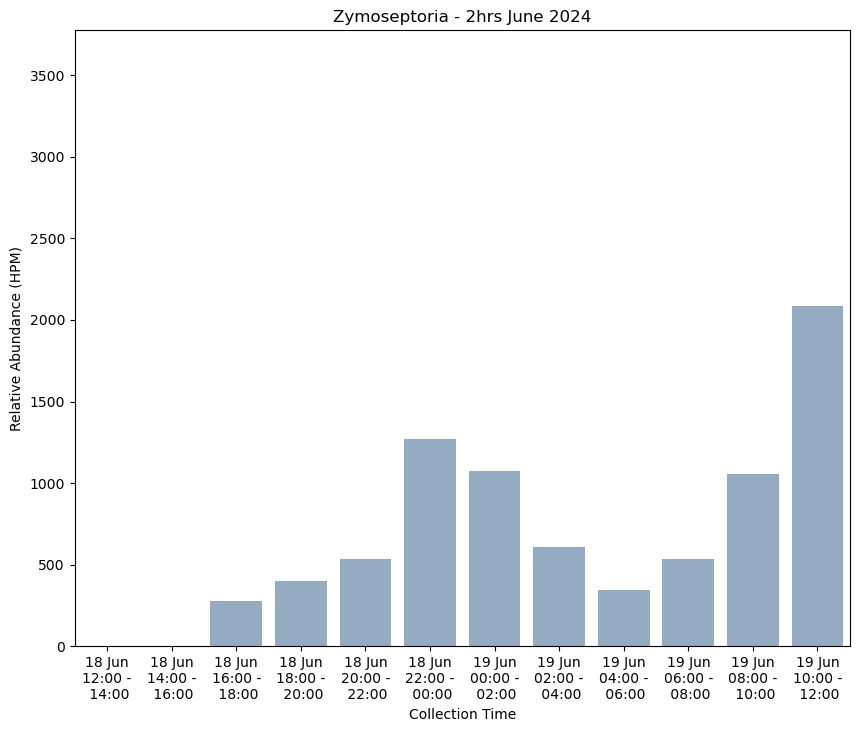

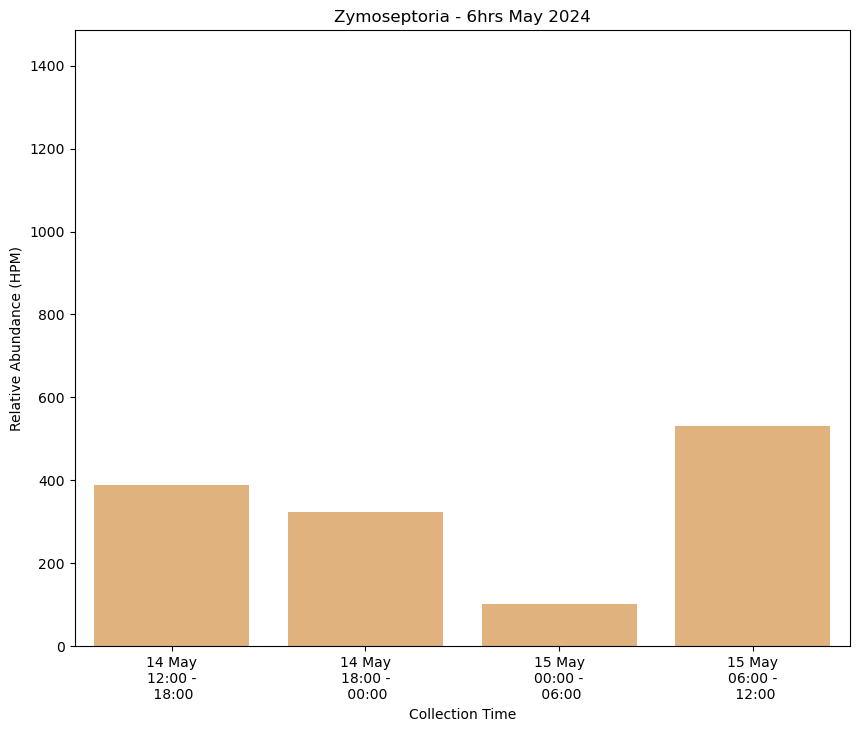

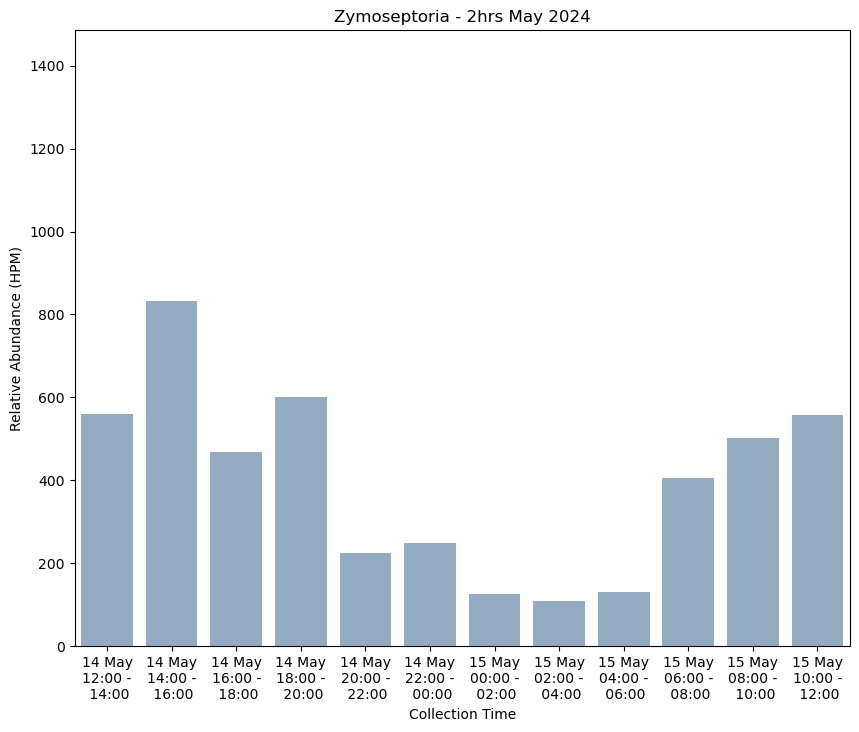

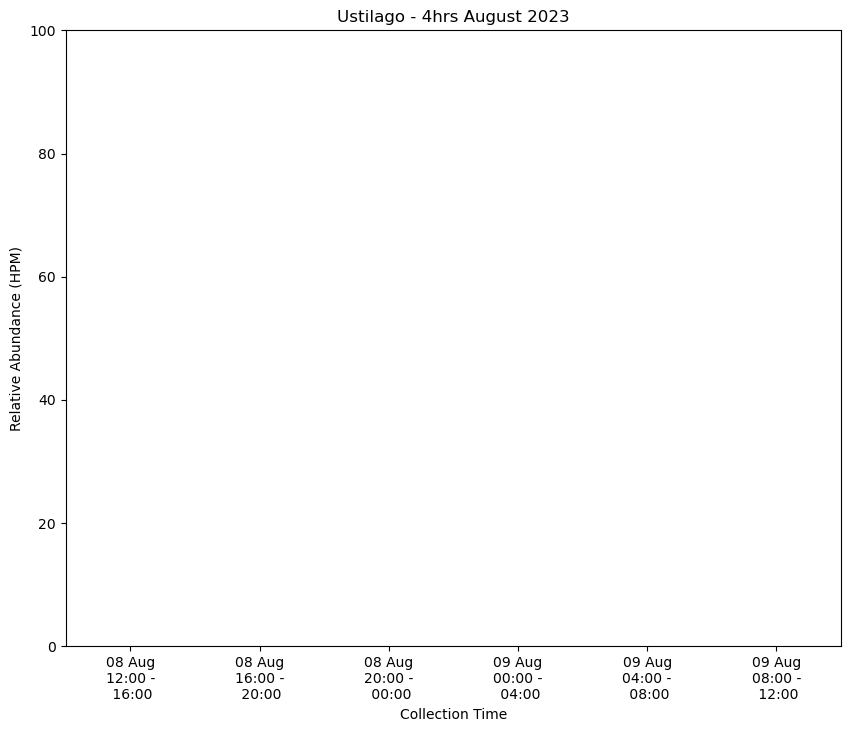

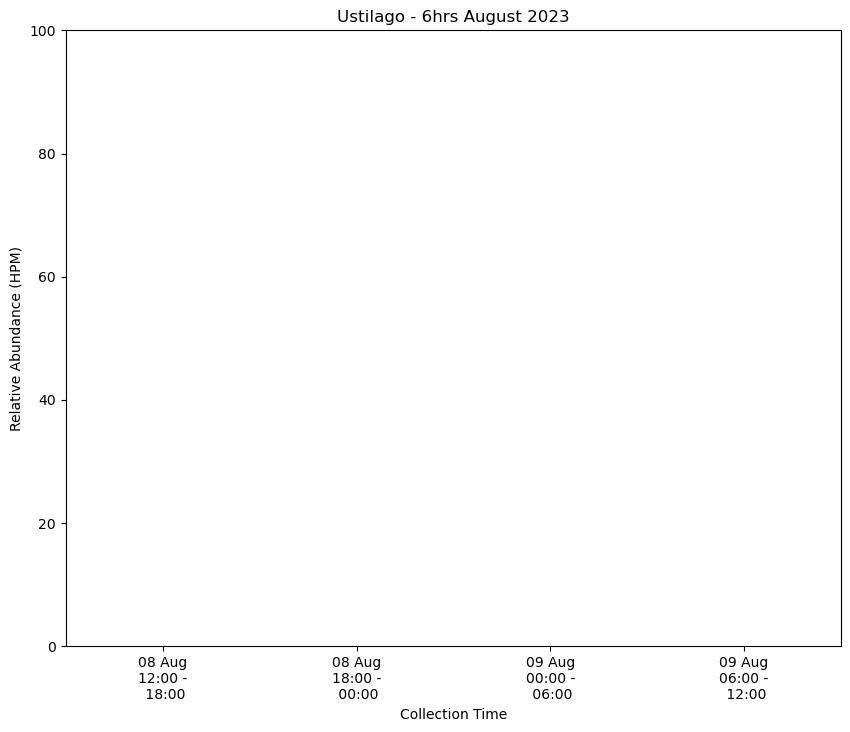

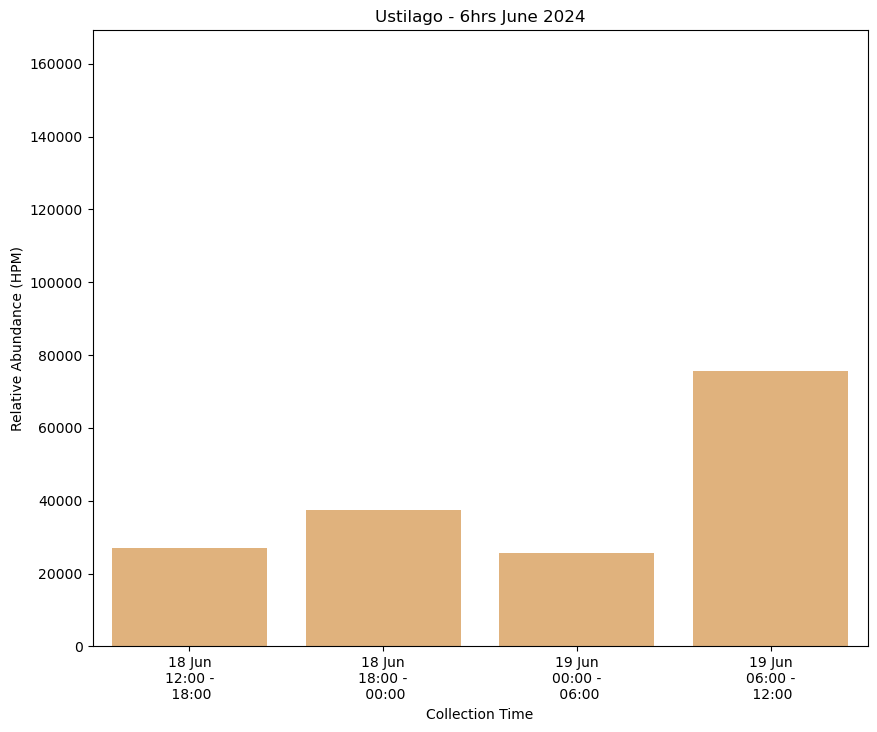

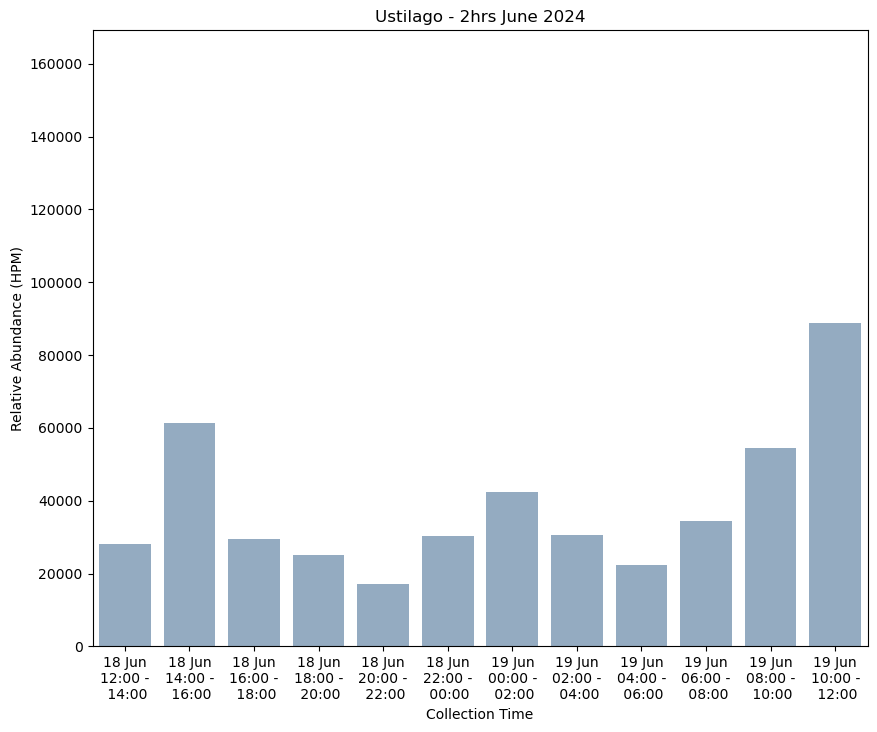

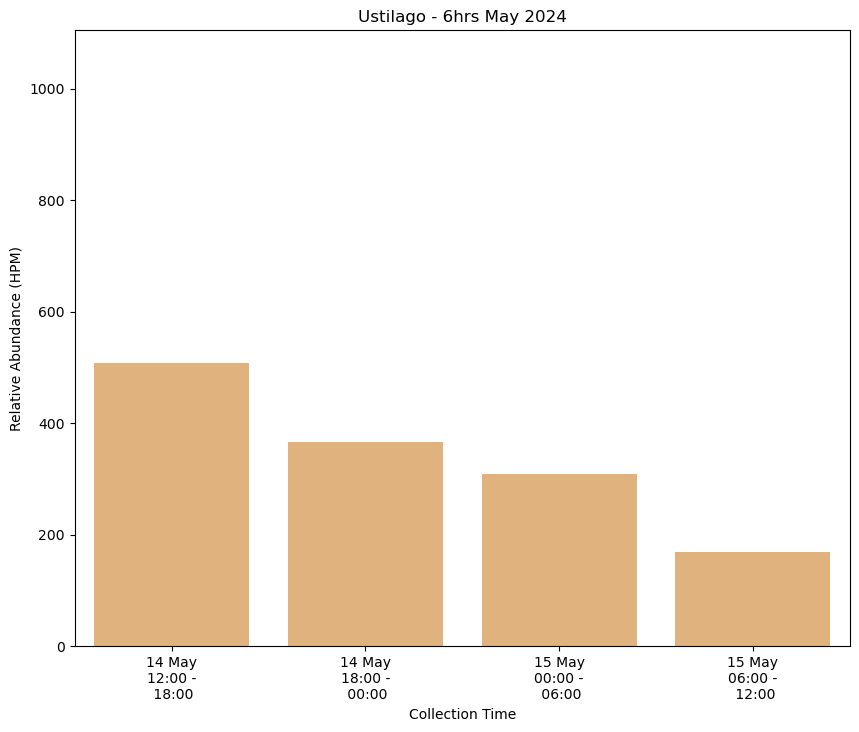

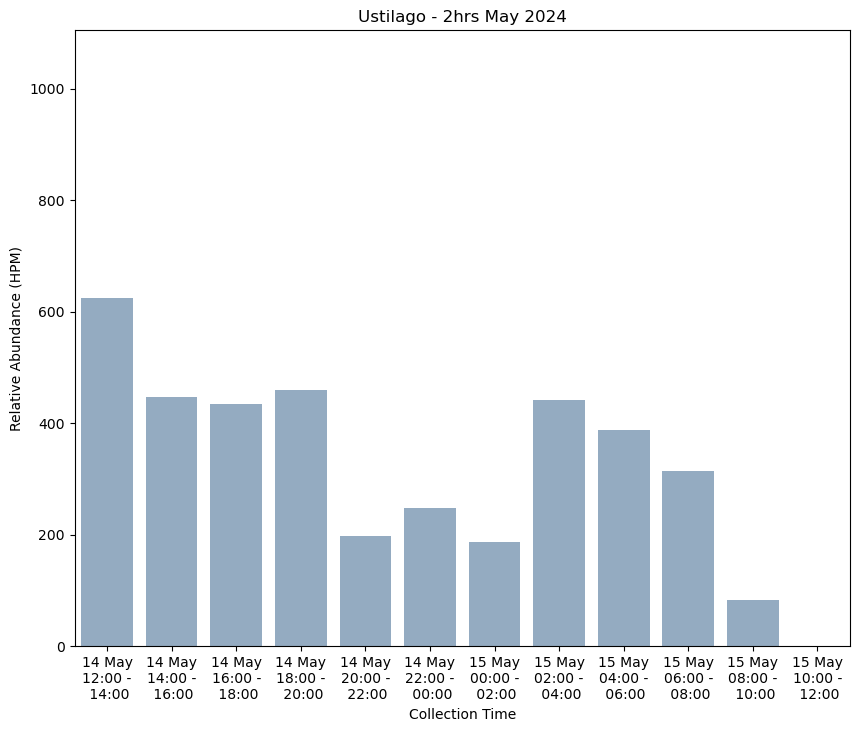

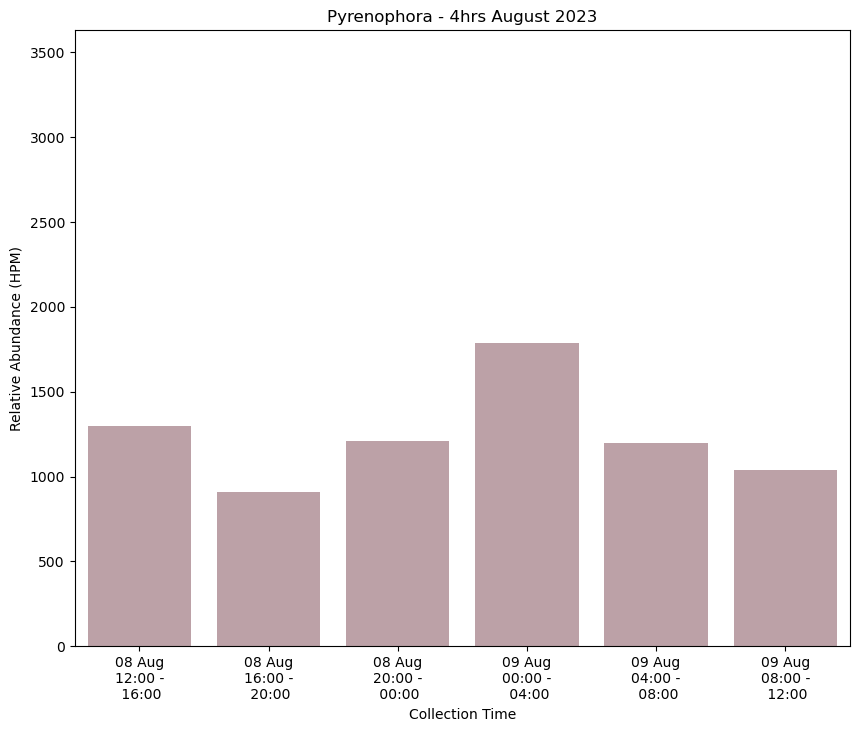

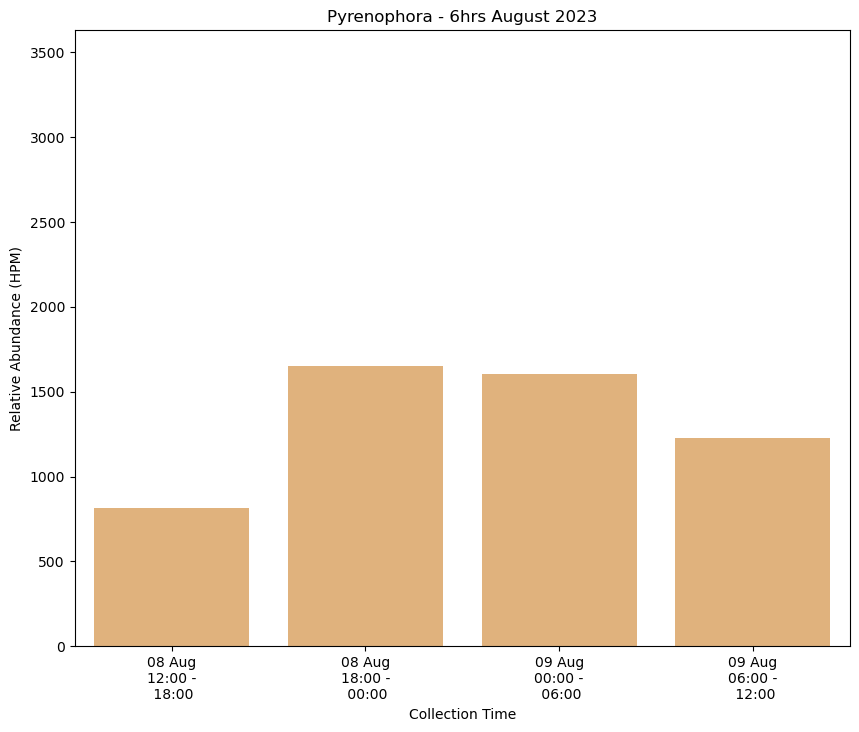

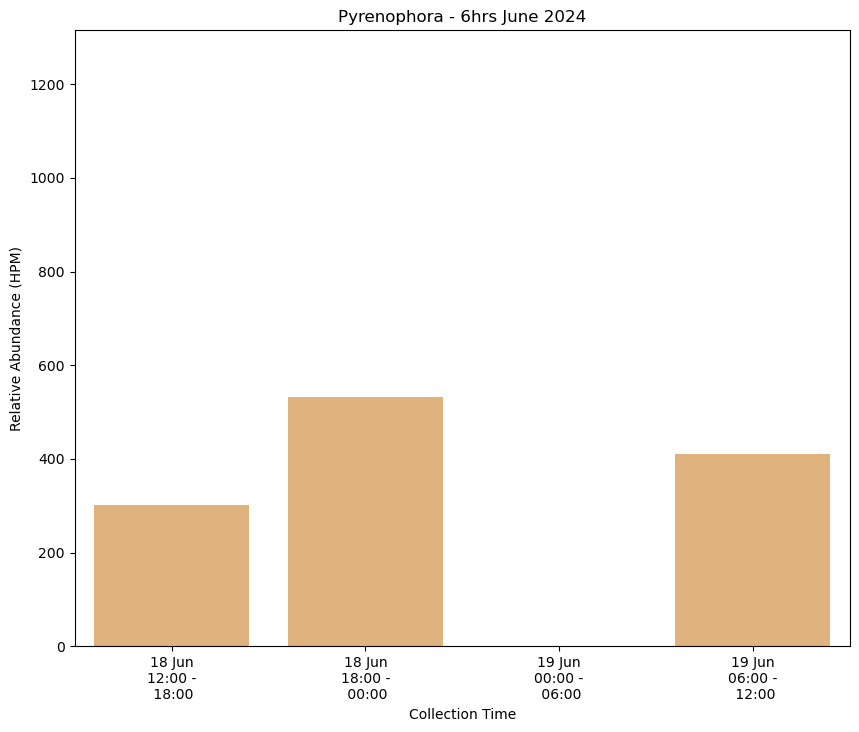

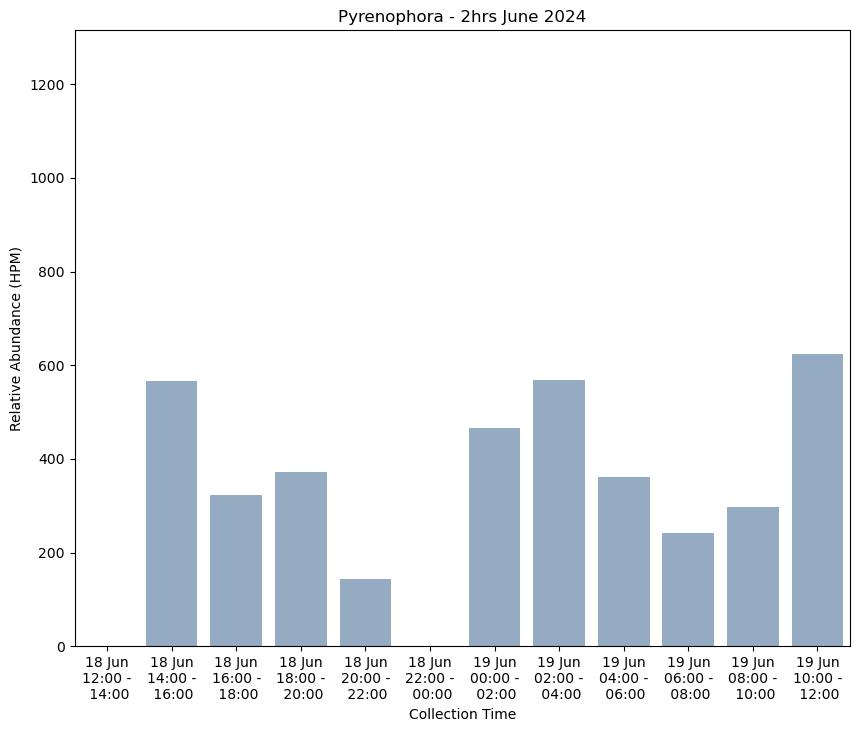

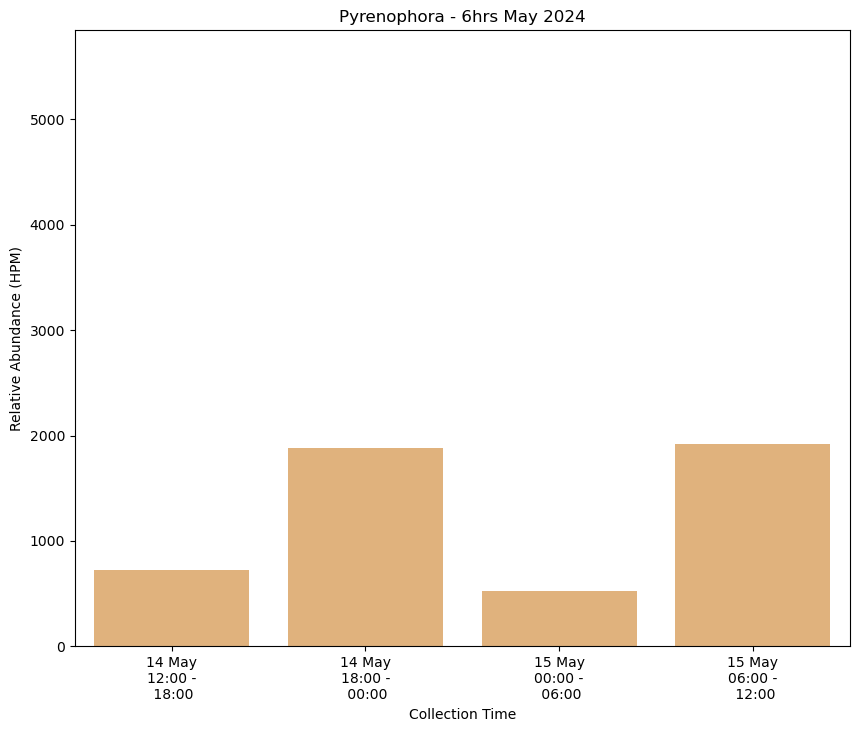

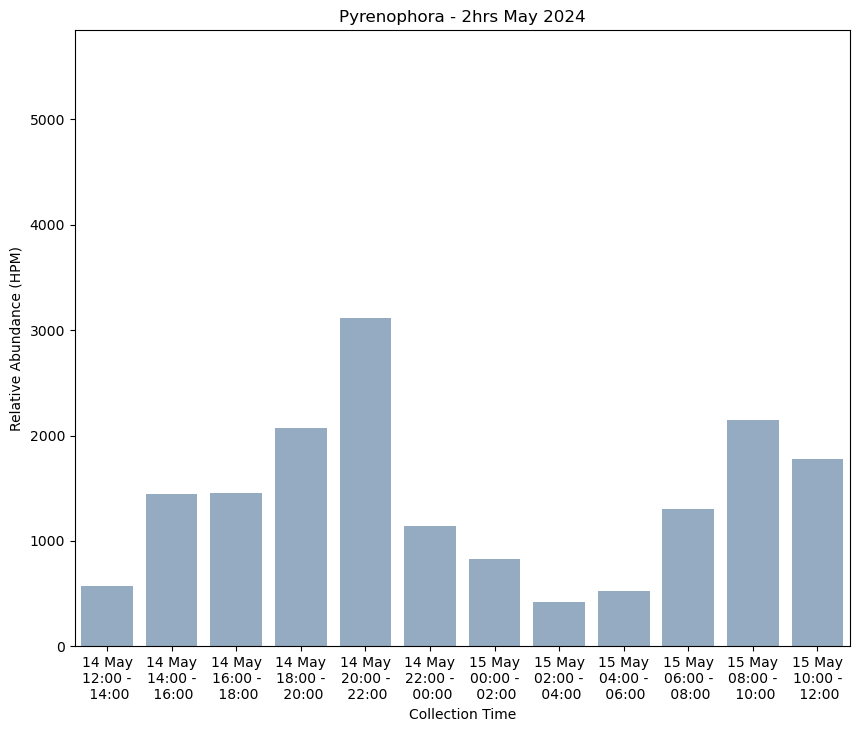

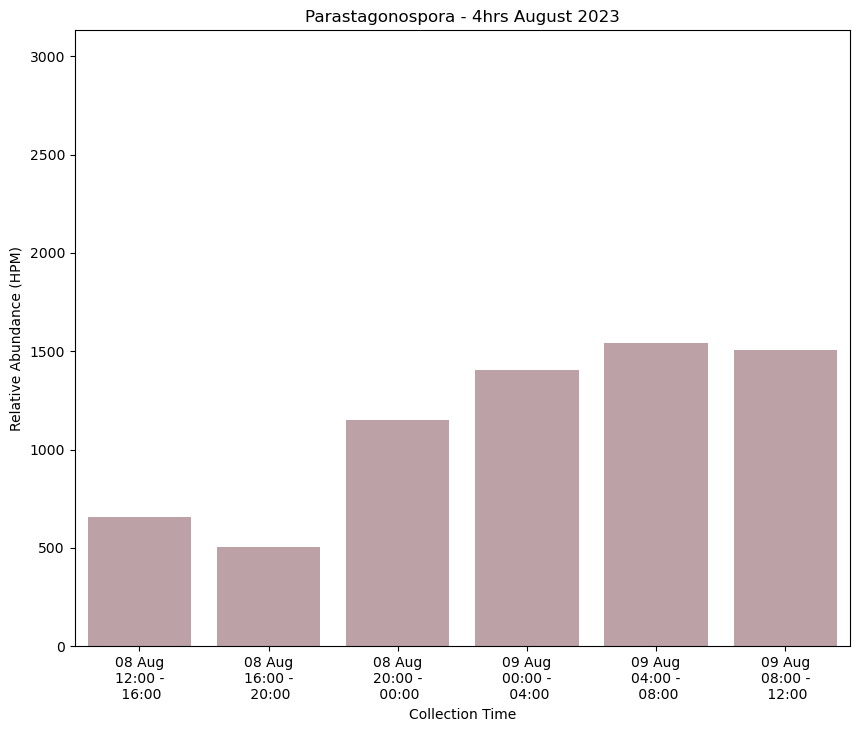

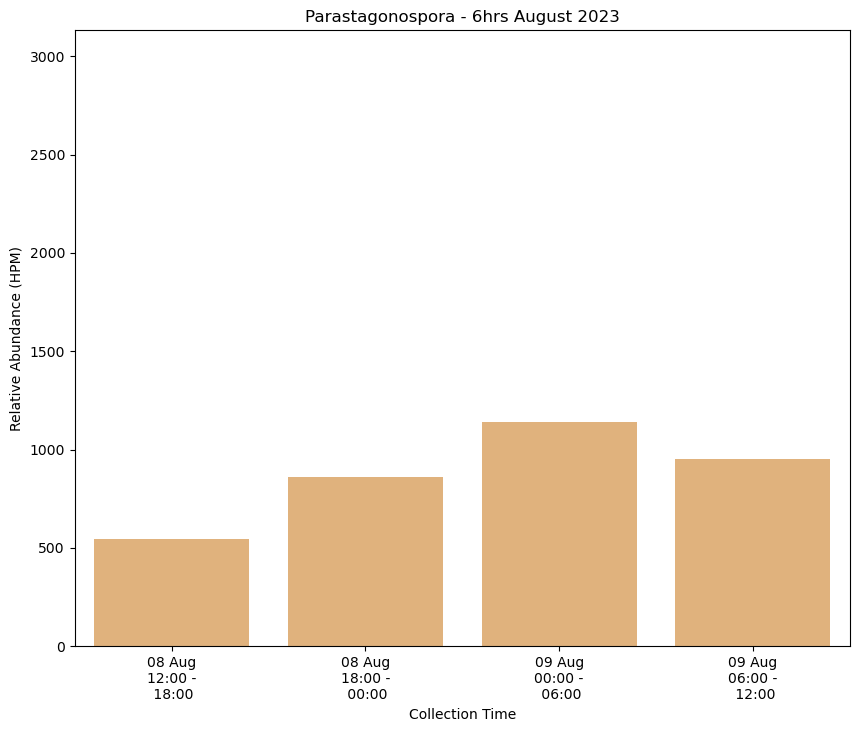

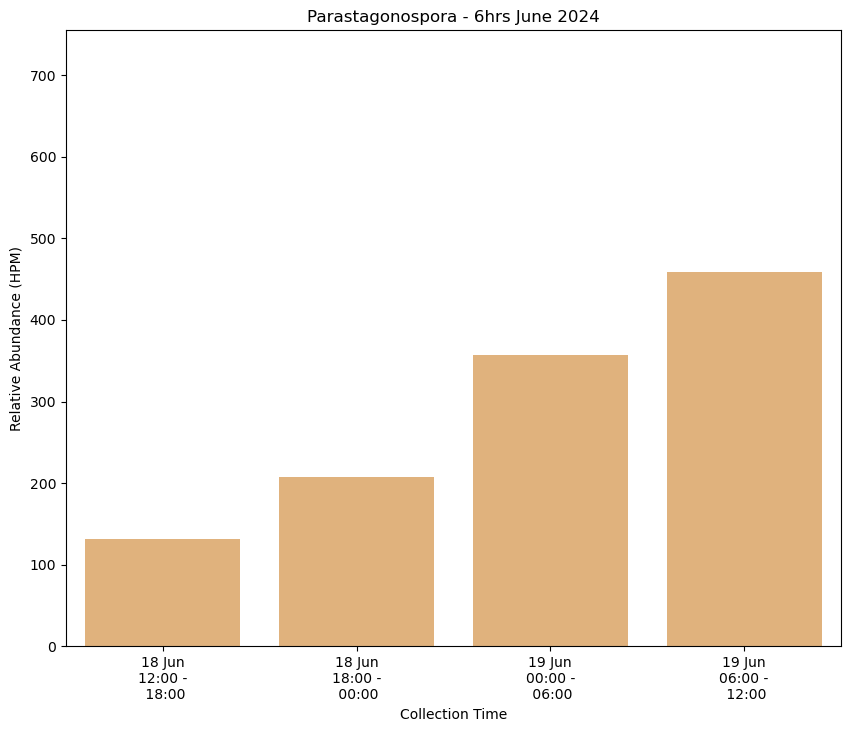

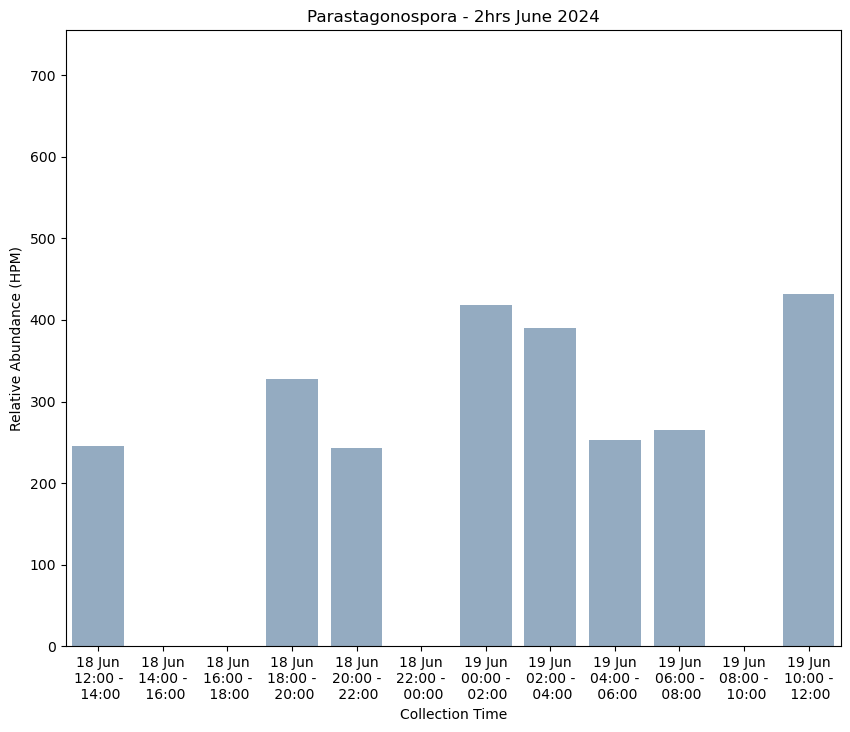

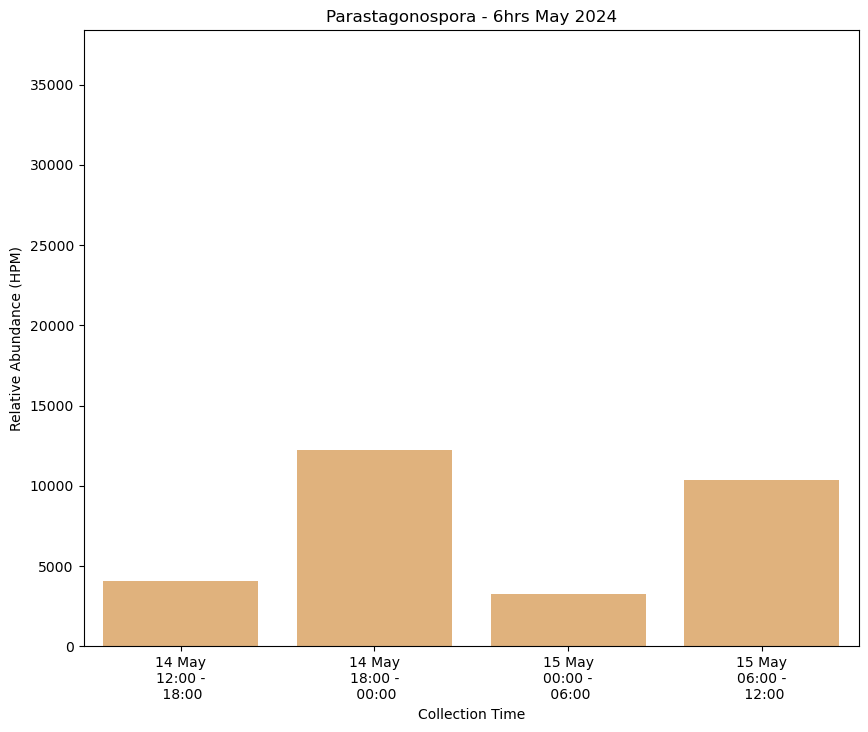

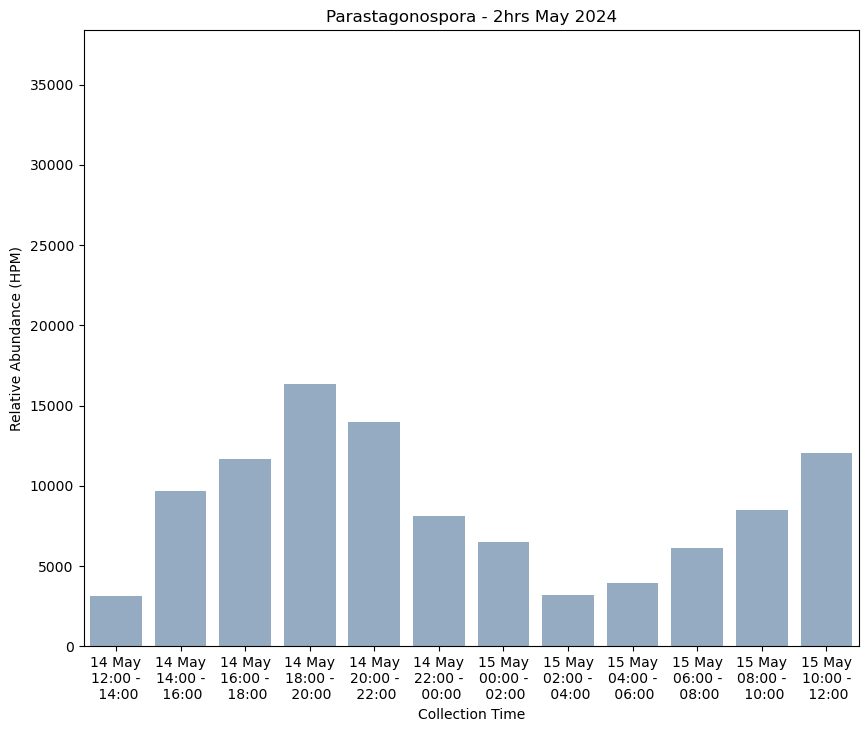

In [39]:
#Loop to plot all the graphs - Makes 40 graphs I might need to manually combine these
#Want to loop through all the diseases, months and durations

pathogen_genera = ["Puccinia", "Blumeria", "Fusarium", "Zymoseptoria", "Ustilago", "Magnaporthe",
                    "Claviceps", "Pyrenophora", "Parastagonospora"]

# Define a color palette for different durations
duration_colors = {2: '#8DABC8', 4: '#c09ca4', 6: '#F0B36D'}

for pathogen in pathogen_genera:
    for year in pathogen_reads['Year'].unique():
        for month in pathogen_reads['Month'].unique():
            for duration in pathogen_reads['Duration_Hrs'].unique():
                filtered_data = pathogen_reads[(pathogen_reads['Name'] == pathogen) &
                                            (pathogen_reads['Month'] == month) &
                                            (pathogen_reads['Duration_Hrs'] == duration) &
                                            (pathogen_reads['Year'] == year)]
                if not filtered_data.empty:
                    plot_bar_disease(pathogen_reads, month, year, pathogen, int(duration), duration_colors.get(int(duration), '#000000'))

## Radial plots

- Did not find these easy to plot in python so instead have made them in R
- However, decided they didn't show the data in an easily interpretable way 

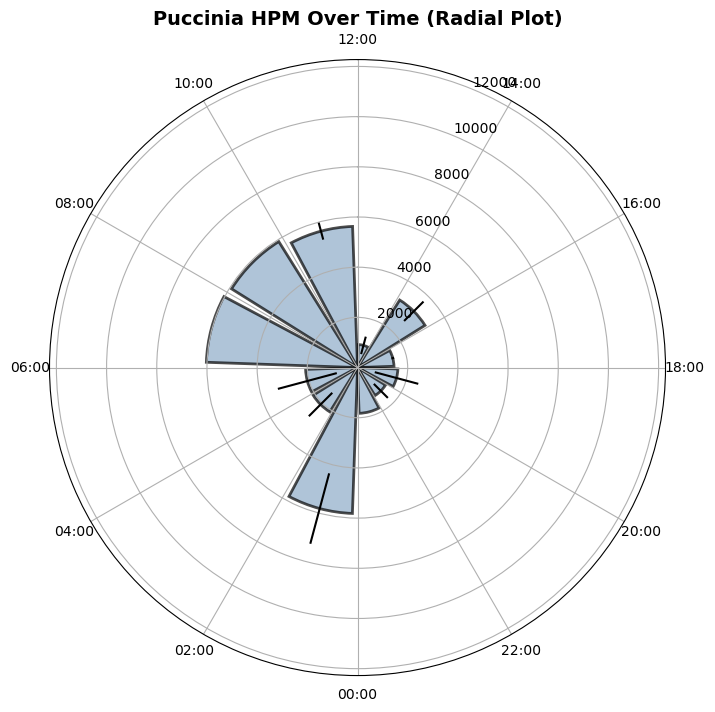

In [16]:
filtered_data = pathogen_reads[(pathogen_reads['Month'] == 'June') &
                                (pathogen_reads['Year'] == 2024) &
                                (pathogen_reads['Name'] == 'Puccinia') &
                                (pathogen_reads['Duration_Hrs'] == 2) & # Need to remove this if I want to plot multiple
                                (pathogen_reads['read count'] > 5)] # can change this filtering to be

# Compute mean and standard deviation of HPM for each time point and retain the Start_Time column
grouped_data = filtered_data.groupby(["Collection", "Start_Time"]).agg({"HPM": ["mean", "std"]}).reset_index()
grouped_data.columns = ["Collection", "Start_Time", "HPM_mean", "HPM_std"]

# Convert time to hours and then to radians (shifted so 12 PM is at the top)
grouped_data["hour"] = grouped_data["Start_Time"].dt.hour + grouped_data["Start_Time"].dt.minute / 60
grouped_data["angle"] = ((grouped_data["hour"] / 24) * 2 * np.pi) + (195 * np.pi / 180)  # Shift by 195° (so they bars start at 12:00)

# Set bar width to 28 degrees (28 degrees = 28 * π/180 radians)
bar_width_2 = 26 * np.pi / 180

# Create polar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

# Plot bars
bars = ax.bar(
    grouped_data["angle"], 
    grouped_data["HPM_mean"], 
    width=bar_width_2, 
    bottom=0, 
    color='#8DABC8', 
    edgecolor='black', 
    linewidth=2,  # Adjust thickness of the outside edge
    alpha=0.7  # Adjust transparency
)

# Plot error bars as straight lines
for i in range(len(grouped_data)):
    ax.plot(
        [grouped_data["angle"][i], grouped_data["angle"][i]],  # X-coordinates
        [grouped_data["HPM_mean"][i] - grouped_data["HPM_std"][i], 
         grouped_data["HPM_mean"][i] + grouped_data["HPM_std"][i]],  # Y-coordinates
        color='black', 
        linewidth=1.5  # Adjust thickness if needed
    )

# Rotate so 12 PM is at the top
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

# Set theta (angle) labels to correspond to time (12 PM at top)
ax.set_xticks(np.linspace(0, 2*np.pi, 12, endpoint=False))  # 12 major ticks
ax.set_xticklabels(['12:00', '14:00', '16:00', '18:00', '20:00', '22:00', 
                    '00:00', '02:00', '04:00', '06:00', '08:00', '10:00'])

# Set radial limits
ax.set_ylim(0, grouped_data["HPM_mean"].max() + grouped_data["HPM_std"].max())

# Title
ax.set_title("Puccinia HPM Over Time (Radial Plot)", fontsize=14, fontweight='bold')

plt.show()
